In [1]:
import os
import sys
import psutil

import pandas as pd
import numpy as np

import keras
import random

from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Activation,Dropout,BatchNormalization,Input,Embedding
from keras.layers import Flatten,Conv2D,MaxPooling2D,Bidirectional,concatenate

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
import keras_metrics as km

import matplotlib
import matplotlib.pyplot as plt
import math
from multiprocessing import cpu_count,Pool 
import multiprocessing


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from keras_self_attention import SeqSelfAttention


/usr/local/anaconda5/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    weights = K.variable(weights)      
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [3]:
SEQ=8
verbose = 2
dropout=0.3
ACT_POSTERIOR = 'relu'
weights = np.array([0.2,0.8])
patience = 10
weight_decay = 0.0001
lr=0.1
lr_decay=1e-6

LSTM_UNIT = 128
GEOHASH_UNIT = 32
EMBEDDING_UNIT = 128
NLP_UNIT = 128
SEQ_UNIT = 256
ACT_PRIOR = 'sigmoid'
DENSE_CONCAT = 256
VAL_SPLIT = 0.2
CONV_UNIT = 32
ADD_ON_LAYERS = True
Embedding_outdim = 100

In [4]:
def reshape_cat(array,category):
    l=[]
    b = array[:,0:-114]
    if category!='geohash' and  category!='NLP' :
        for i in range(SEQ):
            c = b[:,i*25:i*25+25]
            if category == 'traffic':
                #d = np.concatenate((c[:,0:9],c[:,-5:]),axis=1)
                d = np.concatenate([c[:,1:2],c[:,3:10]],axis=1)
            elif category=='weather':
                d = c[:,10:-5]
            elif category=='time':
                d = np.concatenate([c[:,0:1],c[:,2:3],c[:,-5:]],axis=1) 
            else:
                d = c
            l.append(d)        
        n = np.concatenate(l,axis=1)
        #if category!='no_geohash':
        #    return np.concatenate((n,array[:,-14:]),axis=1)
        return n
    elif category=='NLP':
        return array[:,-100:]
    else:
        return array[:,-114:-100]

In [5]:
# Compute ROC curve and ROC area for each class
def roc_auc_compute(y_test,y_score,n_classes=2):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i],pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(),pos_label=1)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr,tpr,roc_auc
def plot_roc(fpr,tpr,roc_auc,n_classes=2):
    lw = 2
# Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(2)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
class base_model(object):        
    def __init__(self,n_jobs=10,act=ACT_POSTERIOR,city='Atlanta'): 
        self.n_jobs=n_jobs
        self.CITY=city
        self.act=act
   
    def load_data(self,category=None,with_geocode=False):
        self.X_train = np.load('train_set/X_train_'+self.CITY+'.npy')
        self.y_train = np.load('train_set/y_train_'+self.CITY+'.npy')
        self.X_test = np.load('train_set/X_test_'+self.CITY+'.npy')
        self.y_test = np.load('train_set/y_test_'+self.CITY+'.npy')
        
        if not with_geocode:
            self.X_train = self.X_train[:,0:-1]    
            self.X_test = self.X_test[:,0:-1]     
        self.update_y()   
        
        if category!=None:
            if with_geocode:
                temp_train = self.X_train[:,0:-1]    
                temp_test = self.X_test[:,0:-1]   
            else:
                temp_train = self.X_train 
                temp_test = self.X_test  
            l_train=[]
            l_test=[]
            for cat in category:
                l_train.append(reshape_cat(temp_train,cat))
                l_test.append(reshape_cat(temp_test,cat))
            temp_train = np.concatenate(l_train,axis=1)
            temp_test = np.concatenate(l_test,axis=1)
            if with_geocode:
                #print (self.X_train[:,-1:])
                self.X_train = np.concatenate((temp_train,self.X_train[:,-1:]),axis=1)
                self.X_test = np.concatenate((temp_test,self.X_test[:,-1:]),axis=1)
            else:
                self.X_train = temp_train
                self.X_test = temp_test
                
        print ('load and test: shapes for train and test, X/Y')
        print (self.X_train.shape)
        print (self.y_train.shape)
        print (self.X_test.shape)
        print (self.y_test.shape)
    
    def update_y(self):
        self.y_train = to_categorical(self.y_train,2)
        self.y_test = to_categorical(self.y_test,2)
    def last_layers(self,model_in):
        model_in = Dense(DENSE_CONCAT,
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=self.act)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/2),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        model_in = Dropout(dropout)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/8),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        #model_in = Dropout(dropout)(model_in)
        ######################################
        main_output = Dense(self.output_dim, activation=self.activation)(model_in)
        return main_output
        
class keras_model(base_model):
    def __init__(self,city='Atlanta',activation='softmax',batch_size=256,epoch = 60,n_jobs=1,act=ACT_POSTERIOR):
        super(keras_model,self).__init__(act=act,city=city)
        self.output_dim = 2
        self.activation=activation
        self.batch_size = batch_size
        self.epoch = epoch
        self.n_jobs=n_jobs
        self.weight_decay = weight_decay
        self.lr=lr
        self.lr_decay=lr_decay
        
    def reshape(self,x):
        x = x[:,0:-114]
        x = x.reshape((x.shape[0],SEQ,int(x.shape[1]/SEQ)))
        return x
    
    def compile_model(self,model=None):
        #precision = km.categorical_precision(label=1)
        #recall = km.categorical_recall(label=1)
        f1_score = km.categorical_f1_score(label=1)
        self.earlyStopping = EarlyStopping(monitor='val_f1_score', 
                                           #monitor = 'val_categorical_f1_score',
                                           restore_best_weights=True,
                                           patience=patience, verbose=0, mode='max'#,baseline=0.1
                                          )
        adam  = optimizers.Adam(lr=self.lr, decay=self.lr_decay)
        loss=weighted_categorical_crossentropy(weights)
        self.model.compile(optimizer=adam, loss=loss#'categorical_crossentropy'
                           ,metrics=[f1_score])
    def create_model(self):
        self.model = KerasClassifier(build_fn=self.build_model, epochs=self.epoch, batch_size=self.batch_size, verbose=1)
    def make_report(self,y_true,y_pred):
        data_frame = classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),output_dict=True)
        df = pd.DataFrame(data_frame)
        df = df.reset_index()
        roc_dict = self.roc_auc(y_true,y_pred)
        df = df.append({'index':'auc','0': roc_dict[0], '1': roc_dict[1],
                   'micro avg': roc_dict['micro'],
                   'macro avg':roc_dict['macro']}, ignore_index=True)
        df = df.set_index('index')
        display(df)
        return df
        
    def roc_auc(self,y_test,y_score):
        fpr,tpr,roc_auc = roc_auc_compute(y_test,y_score)
        plot_roc(fpr,tpr,roc_auc)
        return roc_auc
         
        

In [7]:
class DNN(keras_model):
        
    def create_model(self):
        input1 = Input(shape=(self.X_train.shape[1],),dtype='float32',name='main_input')
        main_output = self.last_layers(input1)
        
        self.model = Model(inputs=[input1], outputs=main_output)
        
        
        #keras.layers.Dense(units, activation=None, use_bias=True, 
        #kernel_initializer='glorot_uniform', bias_initializer='zeros', 
        #kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
        #kernel_constraint=None, bias_constraint=None)
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit(self.X_train, self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict(self.X_test,verbose=verbose)
        return self.make_report(y_true, y_pred)
        

In [8]:
class model_LSTM_aug_wo_NLP_wo_geohash(keras_model):       
    def load_data(self,category):
        super(model_LSTM_aug_wo_NLP_wo_geohash,self).load_data(category)
        self.X_train1 = self.reshape(self.X_train)
        self.X_test1 = self.reshape(self.X_test)
        
        #self.X_train2 = reshape_cat(self.X_train,'geohash')
        #self.X_train3 = reshape_cat(self.X_train,'NLP')
        
        #self.X_test2 = reshape_cat(self.X_test,'geohash')
        #self.X_test3 = reshape_cat(self.X_test,'NLP')
        
        print (self.X_train1.shape)
        #print (self.X_train2.shape)
        #print (self.X_train3.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        #input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        #geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        #input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        #nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        level_2 = lstm
        #print (lstm.shape)
        main_output = self.last_layers(level_2)
        #print (main_output.shape)
        self.model = Model(inputs=input1, outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit(self.X_train1, self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict(self.X_test1,verbose=verbose)
        return self.make_report(y_true, y_pred)
        

In [9]:
class model_LSTM_aug_embed_wo_NLP_wo_geohash(keras_model):
    
    def load_data(self,category):
        super(model_LSTM_aug_embed_wo_NLP_wo_geohash,self).load_data(category,with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        #self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        #self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        #self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        #self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        #print (self.X_train2.shape)
        #print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        #input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        #geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        #input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        #nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm,embeding])
        
        main_output = self.last_layers(level_3)
        
        self.model = Model(inputs=[input1,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)
        
        


In [10]:
class model_LSTM_aug_embed_att_wo_NLP_wo_geohash(keras_model):
    
    def load_data(self,category):
        super(model_LSTM_aug_embed_att_wo_NLP_wo_geohash,self).load_data(category,with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        #self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        #self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        #self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        #self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        #print (self.X_train2.shape)
        #print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        
        lstm = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                                kernel_regularizer=keras.regularizers.l2(self.weight_decay),
                                bias_regularizer=keras.regularizers.l1(self.weight_decay),
                                   attention_regularizer_weight=self.weight_decay,
                                attention_activation=self.act)(lstm)
        lstm = Flatten()(lstm)
        
        lstm_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(lstm)
        """
        att = Dense(1, activation='tanh')(LSTM1)
        att = Activation('softmax')(att)
        merge = keras.layers.Multiply()([LSTM1,att])
        
        att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                      
                       
                       name='Attention')(lstm)
        """ 
        
        ######################################
        #input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        #geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        #input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        #nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm_vec,embeding])
        
        main_output = self.last_layers(level_3)
        self.model = Model(inputs=[input1,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)


In [11]:

    
def compare_models(city='Atlanta',vr=2,drop=0.2,val_split=0.2,p=15,w_d=0,LR=0.01,lr_dc=1e-6,
                   add_on_layer=True,
                   w=[1,1],
                   act_prior = 'sigmoid',act_posterior='relu',
                   lstm_unit=128,geohash_unit=128,embedding_unit=128,nlp_unit=128,seq_unit=256,
                   dense_concat=512,conv_unit=32,classname='DNN'
                  ):

    #global SEQ=8
    global verbose
    global dropout
    global ACT_POSTERIOR
    global ACT_PRIOR
    global weights
    global patience
    global weight_decay
    global lr
    global lr_decay
    
    global GEOHASH_UNIT
    global EMBEDDING_UNIT 
    global NLP_UNIT
    global SEQ_UNIT
    
    global LSTM_UNIT
    global DENSE_CONCAT
    global CONV_UNIT
    global ADD_ON_LAYER
    global VAL_SPLIT
    global Embedding_outdim
    verbose = vr
    dropout=drop
    weights = np.array(w)
    patience = p
    weight_decay = w_d
    lr=LR
    lr_decay=lr_dc
    
    ACT_PRIOR = act_prior
    ACT_POSTERIOR = act_posterior
    
    LSTM_UNIT = lstm_unit
    GEOHASH_UNIT = geohash_unit
    EMBEDDING_UNIT = embedding_unit
    NLP_UNIT = nlp_unit
    SEQ_UNIT = seq_unit
    DENSE_CONCAT = dense_concat
    CONV_UNIT = conv_unit
    Embedding_outdim = embedding_unit
    
    ADD_ON_LAYER = add_on_layer
    VAL_SPLIT = val_split
    def initialte_class(classname):
        if classname=='DNN':
            mypred = DNN(city=city)
            return mypred
        if classname=='RNN':
            mypred = model_LSTM_aug(city=city)
            return mypred
        if classname=='RNN_wo_geohash':
            mypred = model_LSTM_aug_wo_geohash(city=city)
            return mypred
        if classname=='RNN_wo_NLP':
            mypred = model_LSTM_aug_wo_NLP(city=city)
            return mypred
        
        if classname=='RNN_wo_NLP_wo_geohash':
            mypred = model_LSTM_aug_wo_NLP_wo_geohash(city=city)
            return mypred
        
        
        if classname=='RNN_embed':
            mypred = model_LSTM_aug_embed(city=city)
            return mypred
        
        if classname=='RNN_embed_wo_geohash':
            mypred = model_LSTM_aug_embed_wo_geohash(city=city)
            return mypred
        
        if classname=='RNN_embed_wo_NLP':
            mypred = model_LSTM_aug_embed_wo_NLP(city=city)
            return mypred
        
        if classname=='RNN_embed_wo_NLP_wo_geohash':
            mypred = model_LSTM_aug_embed_wo_NLP_wo_geohash(city=city)
            return mypred
        
        
        if classname=='RNN_embed_att':
            mypred = model_LSTM_aug_embed_att(city=city)
            return mypred
        
        if classname=='RNN_embed_att_wo_geohash':
            mypred = model_LSTM_aug_embed_att_wo_geohash(city=city)
            return mypred
        
        if classname=='RNN_embed_att_wo_NLP':
            mypred = model_LSTM_aug_embed_att_wo_NLP(city=city)
            return mypred
        
        if classname=='RNN_embed_att_wo_NLP_wo_geohash':
            mypred = model_LSTM_aug_embed_att_wo_NLP_wo_geohash(city=city)
            return mypred
        
        
        
        
        print ('error in name')
        raise
        return None        
    def do_rest(pred,category):
        pred.load_data(category)
        pred.create_model()
        pred.compile_model()
        pred.train()
        return pred
    
    def process_frame(df,i):
        new_df = df[['0','1','weighted avg','micro avg','macro avg']].drop('support',axis=0)
        new_df=new_df.stack().swaplevel()
        new_df.index=new_df.index.map('{0[0]}_{0[1]}'.format) 
        new_df = new_df.to_frame().T
        new_df['run'] = i
        new_df = new_df.set_index('run')
        return new_df
    def rerun(classname,category,name):
        df_list=[]
        for i in range(3):
            print ("*"*20,classname,"*"*20)
            print ('*'*10,' round ', i)
            mypred = initialte_class(classname)
            mypred = do_rest(mypred,category)
            res  = mypred.evaluate()
            df_list.append(process_frame(res,i))
        df = pd.concat(df_list)
        return pd.DataFrame(df.mean(),columns=[classname+' '+name])
    def post_process(df):
        df.columns=['NL','geohash','traffic','weather','time']
        return df
    #NL	geohash	traffic	weather	time
    if classname=='DNN': 
        list_res=[]
        list_res.append(rerun('DNN',['NLP'],'NLP'))
        list_res.append(rerun('DNN',['geohash'],'geohash'))
        list_res.append(rerun('DNN',['traffic'],'traffic'))
        list_res.append(rerun('DNN',['weather'],'weather'))
        list_res.append(rerun('DNN',['time'],'time'))
        df = pd.concat(list_res,axis=1)
        df.columns = ['NL','geohash','traffic','weather','time']
        return df
    if classname=='RNN':
        list_res=[]
        list_res.append(rerun('RNN_wo_NLP_wo_geohash',['traffic','geohash','NLP'],'traffic'))
        list_res.append(rerun('RNN_wo_NLP_wo_geohash',['weather','geohash','NLP'],'weather'))
        list_res.append(rerun('RNN_wo_NLP_wo_geohash',['time','geohash','NLP'],'time'))
        df = pd.concat(list_res,axis=1)
        df.columns = ['traffic','weather','time']
        return df
    if classname=='RNN_embed':
        list_res=[]
        list_res.append(rerun('RNN_embed_wo_NLP_wo_geohash',['traffic','geohash','NLP'],'traffic'))
        list_res.append(rerun('RNN_embed_wo_NLP_wo_geohash',['weather','geohash','NLP'],'weather'))
        list_res.append(rerun('RNN_embed_wo_NLP_wo_geohash',['time','geohash','NLP'],'time'))
        df = pd.concat(list_res,axis=1)
        df.columns = ['traffic','weather','time']
        return df
    """
    if classname=='RNN_embed_att':
        list_res=[]
        list_res.append(rerun('RNN_embed_att_wo_NLP_wo_geohash',['traffic','geohash','NLP'],'traffic'))
        list_res.append(rerun('RNN_embed_att_wo_NLP_wo_geohash',['weather','geohash','NLP'],'weather'))
        list_res.append(rerun('RNN_embed_att_wo_NLP_wo_geohash',['time','geohash','NLP'],'time'))
        
        
        return pd.concat(list_res,axis=1)
    """
    #list_res.append(rerun('RNN'))
    #list_res.append(rerun('RNN_embed'))
   
        
    

# Atlanta

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 100)
(12085, 2)
(2515, 100)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)         

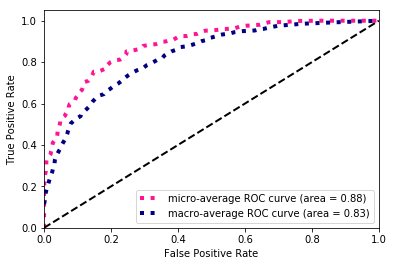

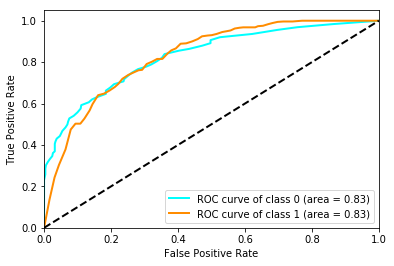

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.871374    0.558590     0.714982     0.800795      0.805335
precision     0.888017    0.524834     0.706426     0.800795      0.811337
recall        0.855343    0.596987     0.726165     0.800795      0.800795
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.829163    0.829163     0.829237     0.883436           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 100)
(12085, 2)
(2515, 100)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)         

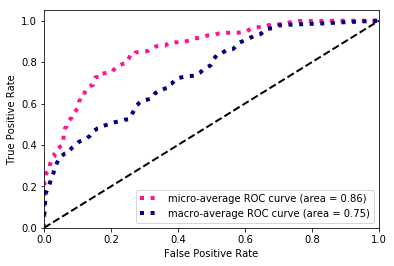

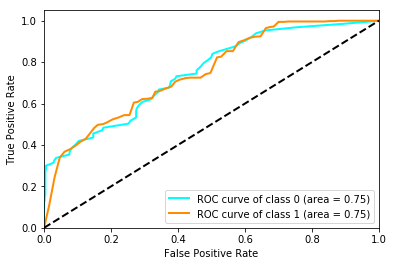

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.863602    0.453731     0.658667     0.781710      0.777065
precision     0.851543    0.481013     0.666278     0.781710      0.773312
recall        0.876008    0.429379     0.652693     0.781710      0.781710
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.749426    0.749426     0.749615     0.861614           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 100)
(12085, 2)
(2515, 100)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)         

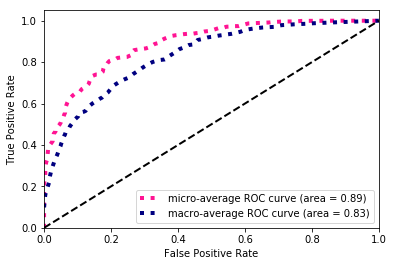

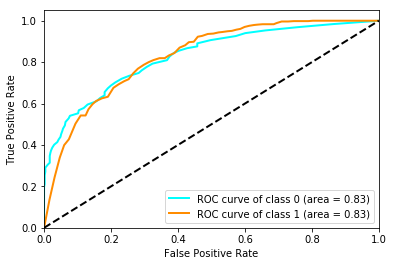

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.875381    0.553734     0.714558     0.805169      0.807471
precision     0.883470    0.536155     0.709813     0.805169      0.810140
recall        0.867440    0.572505     0.719972     0.805169      0.805169
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.828895    0.828895     0.829000     0.887151           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 14)
(12085, 2)
(2515, 14)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               7680      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)           

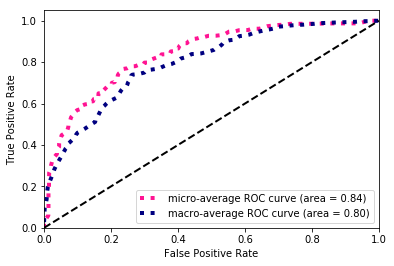

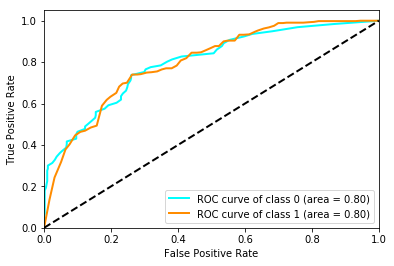

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.844032    0.533333     0.688683     0.766203      0.778433
precision     0.890817    0.460905     0.675861     0.766203      0.800049
recall        0.801915    0.632768     0.717342     0.766203      0.766203
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.796822    0.796822     0.797005     0.838171           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 14)
(12085, 2)
(2515, 14)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               7680      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)           

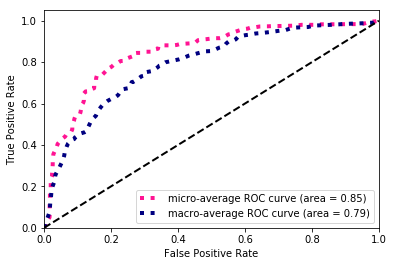

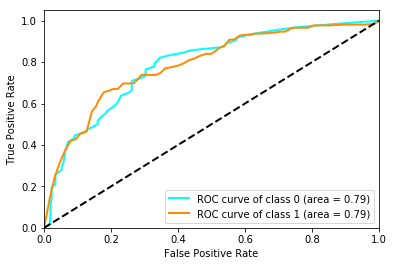

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.862786    0.553299     0.708043     0.790060      0.797443
precision     0.890558    0.502304     0.696431     0.790060      0.808585
recall        0.836694    0.615819     0.726256     0.790060      0.790060
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.787940    0.787940     0.788209     0.848172           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 14)
(12085, 2)
(2515, 14)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               7680      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)           

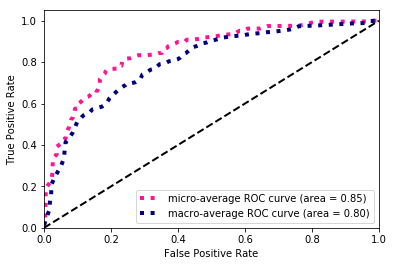

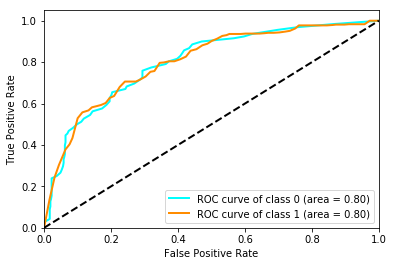

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.855954    0.532095     0.694024     0.779722      0.787577
precision     0.883996    0.482389     0.683192     0.779722      0.799203
recall        0.829637    0.593220     0.711429     0.779722      0.779722
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.800936    0.800936     0.801118     0.850567           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 64)
(12085, 2)
(2515, 64)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               33280     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)           

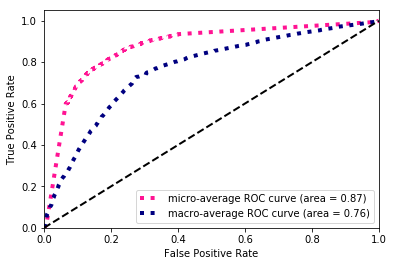

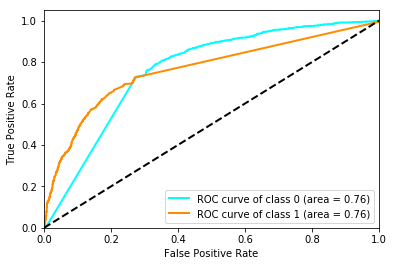

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.884118    0.489796     0.686957     0.811133      0.800864
precision     0.856738    0.570000     0.713369     0.811133      0.796198
recall        0.913306    0.429379     0.671342     0.811133      0.811133
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.762697    0.762697     0.762970     0.873692           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 64)
(12085, 2)
(2515, 64)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               33280     
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)           

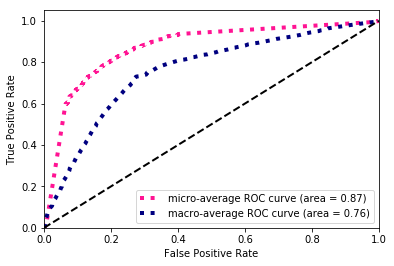

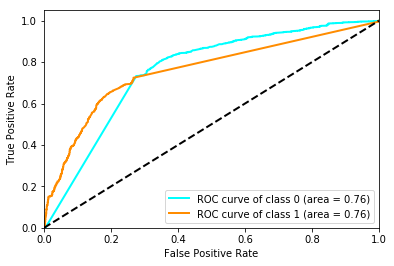

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.878252    0.481172     0.679712     0.802783      0.794415
precision     0.855981    0.541176     0.698579     0.802783      0.789515
recall        0.901714    0.433145     0.667429     0.802783      0.802783
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.758313    0.758313     0.758577     0.870187           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 64)
(12085, 2)
(2515, 64)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               33280     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)           

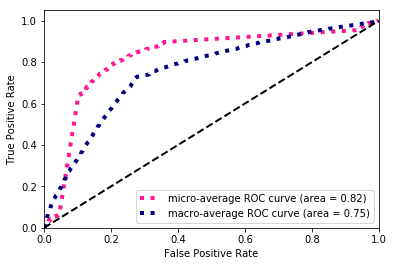

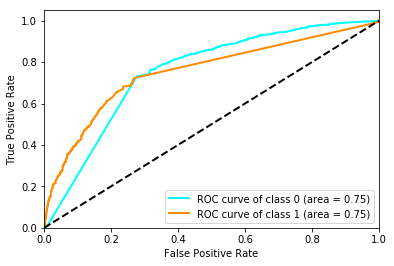

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.870042    0.489716     0.679879     0.792843      0.789743
precision     0.861235    0.510204     0.685719     0.792843      0.787120
recall        0.879032    0.470810     0.674921     0.792843      0.792843
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.752929    0.752929     0.753199     0.822638           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 80)
(12085, 2)
(2515, 80)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               41472     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)           

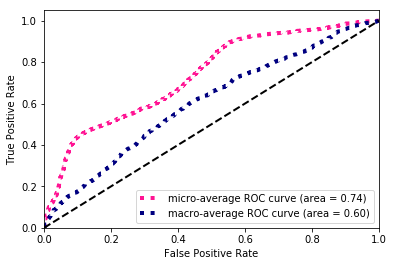

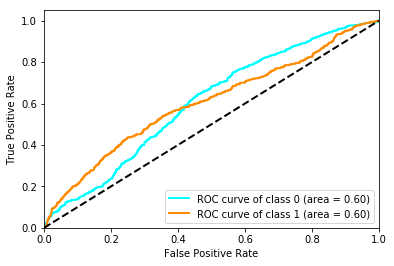

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.739888    0.370068     0.554978     0.631809      0.661806
precision     0.835660    0.289670     0.562665     0.631809      0.720383
recall        0.663810    0.512241     0.588026     0.631809      0.631809
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.603803    0.603803     0.604231     0.735002           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 80)
(12085, 2)
(2515, 80)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               41472     
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
activation_21 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)           

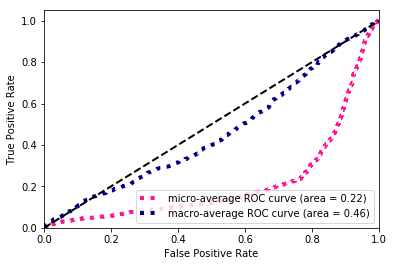

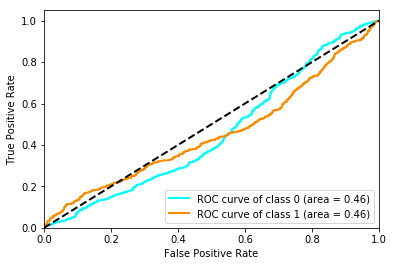

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.104380    0.333564     0.218972     0.235785      0.152769
precision     0.691358    0.204420     0.447889     0.235785      0.588549
recall        0.056452    0.905838     0.481145     0.235785      0.235785
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.456369    0.456370     0.456813     0.216325           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 80)
(12085, 2)
(2515, 80)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               41472     
_________________________________________________________________
dense_46 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
activation_23 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)           

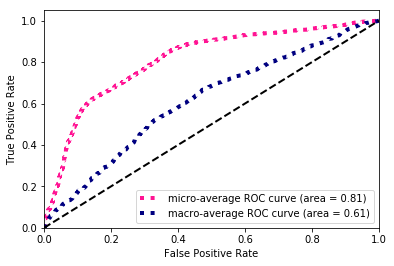

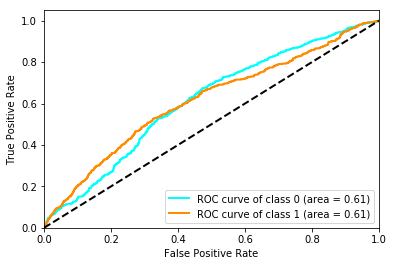

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.835505    0.305296     0.570401     0.733996      0.723560
precision     0.815651    0.340278     0.577964     0.733996      0.715284
recall        0.856351    0.276836     0.566593     0.733996      0.733996
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.612648    0.612648     0.613086     0.809549           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 56)
(12085, 2)
(2515, 56)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)           

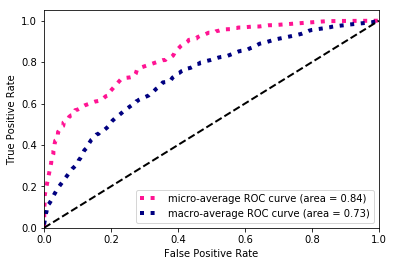

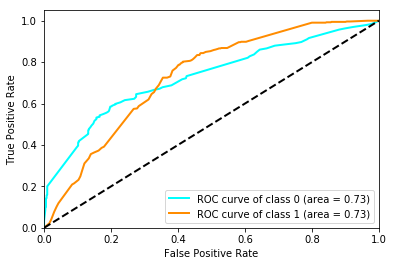

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.827744    0.380256     0.604000     0.730417      0.733264
precision     0.834529    0.369449     0.601989     0.730417      0.736335
recall        0.821069    0.391714     0.606391     0.730417      0.730417
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.728132    0.728132     0.728254     0.840754           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 56)
(12085, 2)
(2515, 56)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)           

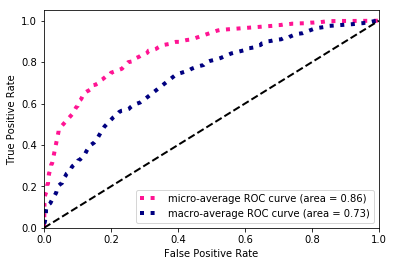

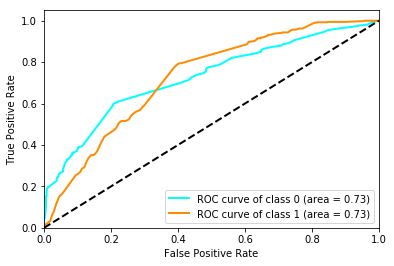

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.860153    0.316159     0.588156     0.767793      0.745298
precision     0.819343    0.417957     0.618650     0.767793      0.734597
recall        0.905242    0.254237     0.579740     0.767793      0.767793
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.726710    0.726710     0.726823     0.860512           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 56)
(12085, 2)
(2515, 56)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
activation_29 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)           

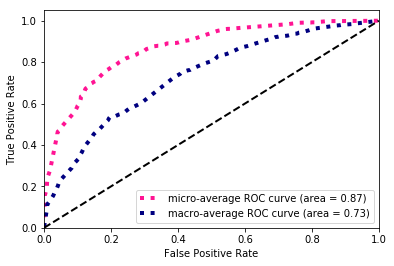

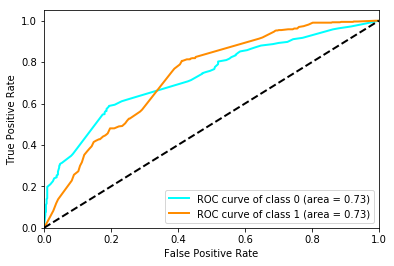

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.878829    0.088136     0.483482     0.786083      0.711887
precision     0.794381    0.440678     0.617530     0.786083      0.719703
recall        0.983367    0.048964     0.516166     0.786083      0.786083
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.731955    0.731955     0.732084     0.866069           NaN

In [12]:
Atlanta = compare_models(classname='DNN')

In [13]:
Atlanta.to_hdf('Atlanta.h5',key='DNN_only')
Atlanta

NL   geohash   traffic   weather      time
0_f1-score              0.870119  0.854257  0.877471  0.559924  0.855575
1_f1-score              0.522019  0.539576  0.486894  0.336309  0.261517
weighted avg_f1-score   0.796624  0.787818  0.795007  0.512712  0.730150
micro avg_f1-score      0.795891  0.778661  0.802253  0.533863  0.761431
macro avg_f1-score      0.696069  0.696917  0.682183  0.448117  0.558546
0_precision             0.874343  0.888457  0.857984  0.780889  0.816084
1_precision             0.514001  0.481866  0.540460  0.278123  0.409361
weighted avg_precision  0.798263  0.802612  0.790944  0.674739  0.730212
micro avg_precision     0.795891  0.778661  0.802253  0.533863  0.761431
macro avg_precision     0.694172  0.685162  0.699222  0.529506  0.612723
0_recall                0.866263  0.822749  0.898017  0.525538  0.903226
1_recall                0.532957  0.613936  0.444444  0.564972  0.231638
weighted avg_recall     0.795891  0.778661  0.802253  0.533863  0.761431
micro avg_recall        0.795891  0.778661  0.802253  0.533863  0.761431
macro avg_recall        0.699610  0.718342  0.671231  0.545255  0.567432
0_auc                   0.802495  0.795233  0.757980  0.557607  0.728933
1_auc                   0.802495  0.795233  0.757980  0.557607  0.728933
micro avg_auc           0.877400  0.845636  0.855506  0.586959  0.855778
macro avg_auc           0.802617  0.795444  0.758248  0.558043  0.729054

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 178)
(12085, 2)
(2515, 178)
(2515, 2)
(12085, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_61 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

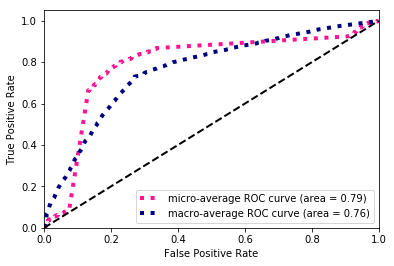

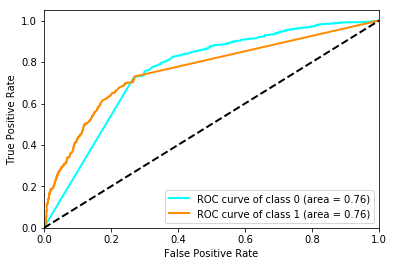

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.860015    0.528236     0.694126     0.784095      0.789966
precision     0.880211    0.490323     0.685267     0.784095      0.797893
recall        0.840726    0.572505     0.706615     0.784095      0.784095
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.761061    0.761061     0.761338     0.787885           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 178)
(12085, 2)
(2515, 178)
(2515, 2)
(12085, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_65 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

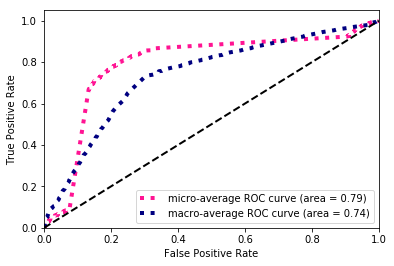

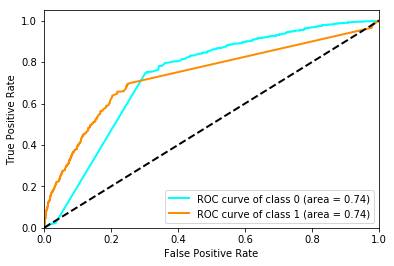

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.864526    0.482759     0.673642     0.785288      0.783922
precision     0.860639    0.491228     0.675934     0.785288      0.782644
recall        0.868448    0.474576     0.671512     0.785288      0.785288
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.735048    0.735048     0.735322     0.788845           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 178)
(12085, 2)
(2515, 178)
(2515, 2)
(12085, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_69 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_70 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

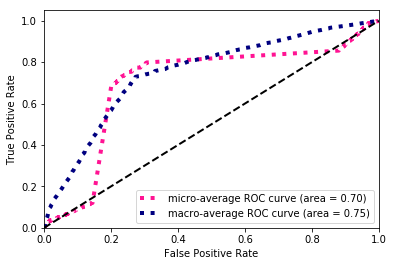

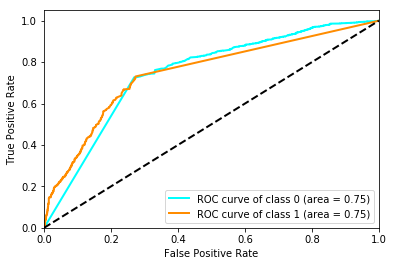

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.832531    0.515480     0.674005     0.751093      0.765591
precision     0.887115    0.437582     0.662349     0.751093      0.792204
recall        0.784274    0.627119     0.705696     0.751093      0.751093
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.746672    0.746672     0.746939     0.698328           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 194)
(12085, 2)
(2515, 194)
(2515, 2)
(12085, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 128)            71168     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_73 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_74 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizat

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


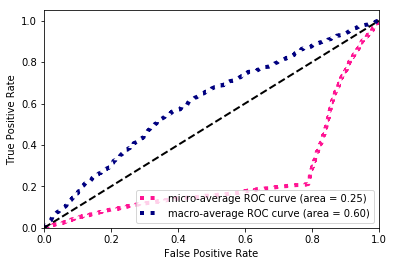

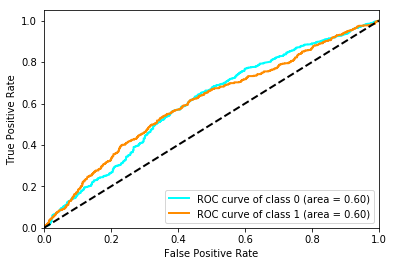

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.000000    0.348654     0.174327     0.211133      0.073612
precision     0.000000    0.211133     0.105567     0.211133      0.044577
recall        0.000000    1.000000     0.500000     0.211133      0.211133
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.604421    0.604420     0.604820     0.245917           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 194)
(12085, 2)
(2515, 194)
(2515, 2)
(12085, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 128)            71168     
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_77 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_78 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizat

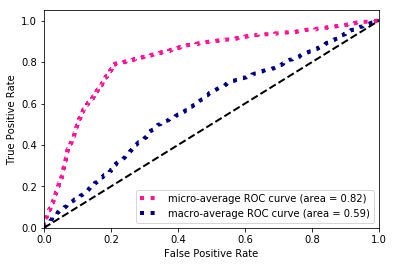

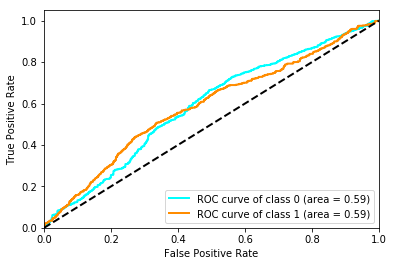

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.881974    0.000000     0.440987     0.788867      0.695760
precision     0.788867    0.000000     0.394433     0.788867      0.622311
recall        1.000000    0.000000     0.500000     0.788867      0.788867
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.587653    0.587656     0.588088     0.818066           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 194)
(12085, 2)
(2515, 194)
(2515, 2)
(12085, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_81 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizat

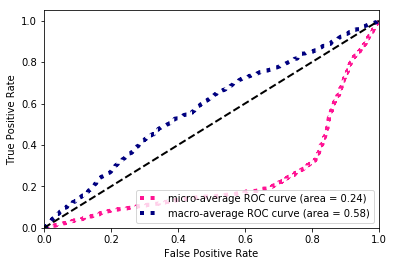

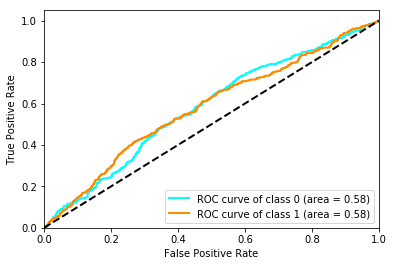

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.123653    0.353713     0.238683     0.256064      0.172227
precision     0.874172    0.216582     0.545377     0.256064      0.735333
recall        0.066532    0.964218     0.515375     0.256064      0.256064
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.578901    0.578901     0.579341     0.243763           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 170)
(12085, 2)
(2515, 170)
(2515, 2)
(12085, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_85 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

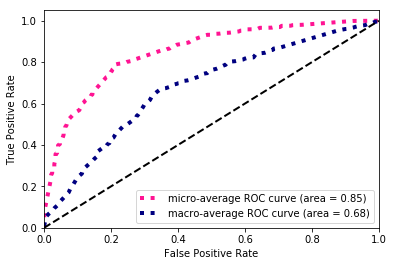

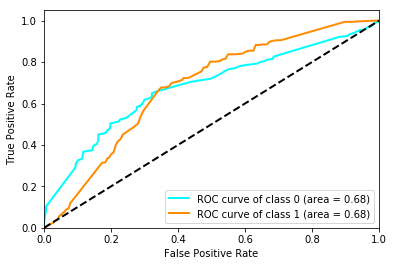

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.881974    0.000000     0.440987     0.788867      0.695760
precision     0.788867    0.000000     0.394433     0.788867      0.622311
recall        1.000000    0.000000     0.500000     0.788867      0.788867
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.679796    0.679796     0.680050     0.848759           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 170)
(12085, 2)
(2515, 170)
(2515, 2)
(12085, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_89 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_90 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

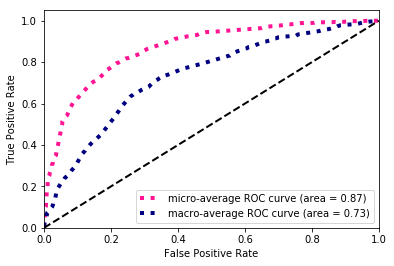

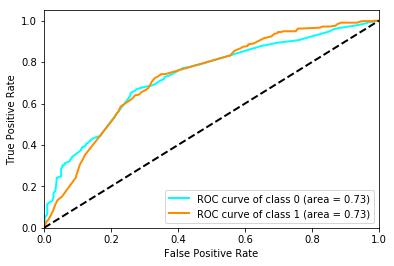

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.881974    0.000000     0.440987     0.788867      0.695760
precision     0.788867    0.000000     0.394433     0.788867      0.622311
recall        1.000000    0.000000     0.500000     0.788867      0.788867
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.732959    0.732959     0.733250     0.866468           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 170)
(12085, 2)
(2515, 170)
(2515, 2)
(12085, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_93 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_94 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

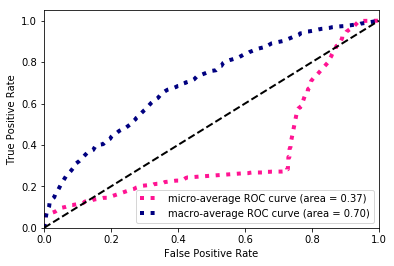

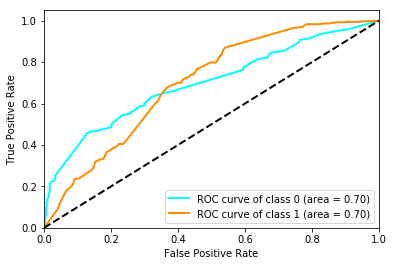

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.158480    0.367688     0.263084     0.277932      0.202651
precision     0.982759    0.225545     0.604152     0.277932      0.822886
recall        0.086190    0.994350     0.540270     0.277932      0.277932
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.698057    0.698057     0.698279     0.367051           NaN

In [14]:
Atlanta = compare_models(classname='RNN')

In [15]:
Atlanta.to_hdf('Atlanta.h5',key='RNN_only')
Atlanta

traffic   weather      time
0_f1-score              0.852357  0.335209  0.640809
1_f1-score              0.508825  0.234122  0.122563
weighted avg_f1-score   0.779826  0.313866  0.531390
micro avg_f1-score      0.773492  0.418688  0.618555
macro avg_f1-score      0.680591  0.284666  0.381686
0_precision             0.875989  0.554346  0.853497
1_precision             0.473044  0.142572  0.075182
weighted avg_precision  0.790914  0.467407  0.689169
micro avg_precision     0.773492  0.418688  0.618555
macro avg_precision     0.674516  0.348459  0.464339
0_recall                0.831149  0.355511  0.695397
1_recall                0.558067  0.654739  0.331450
weighted avg_recall     0.773492  0.418688  0.618555
micro avg_recall        0.773492  0.418688  0.618555
macro avg_recall        0.694608  0.505125  0.513423
0_auc                   0.747593  0.590325  0.703604
1_auc                   0.747593  0.590326  0.703604
micro avg_auc           0.758353  0.435915  0.694093
macro avg_auc           0.747867  0.590750  0.703860

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 179)
(12085, 2)
(2515, 179)
(2515, 2)
(12085, 8, 8)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

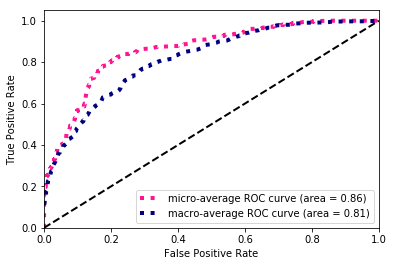

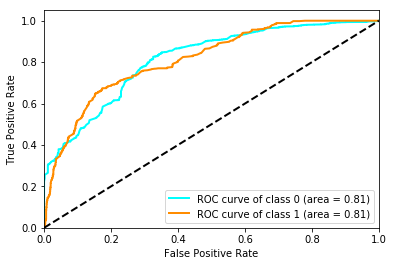

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.870313    0.581513     0.725913     0.801988      0.809337
precision     0.900323    0.525038     0.712681     0.801988      0.821088
recall        0.842238    0.651601     0.746919     0.801988      0.801988
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.814497    0.814497     0.814815     0.859140           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 179)
(12085, 2)
(2515, 179)
(2515, 2)
(12085, 8, 8)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

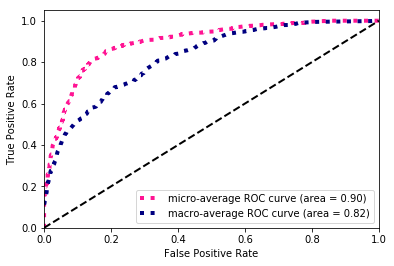

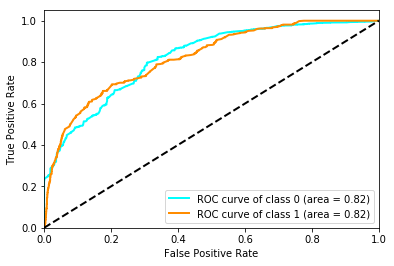

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.894815    0.565306     0.730060     0.830616      0.825245
precision     0.877057    0.616927     0.746992     0.830616      0.822135
recall        0.913306    0.521657     0.717482     0.830616      0.830616
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.820931    0.820931     0.821221     0.895808           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 179)
(12085, 2)
(2515, 179)
(2515, 2)
(12085, 8, 8)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

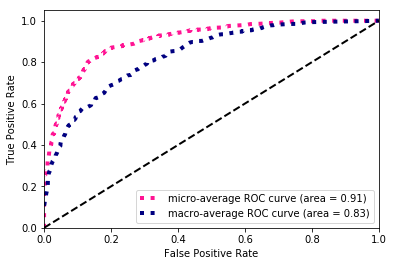

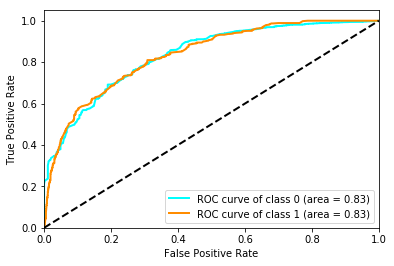

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.893891    0.565350     0.729620     0.829423      0.824525
precision     0.877610    0.611842     0.744726     0.829423      0.821498
recall        0.910786    0.525424     0.718105     0.829423      0.829423
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.834155    0.834158     0.834449     0.906173           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 195)
(12085, 2)
(2515, 195)
(2515, 2)
(12085, 8, 10)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

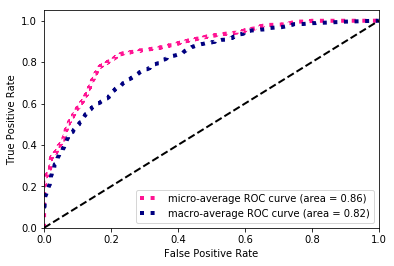

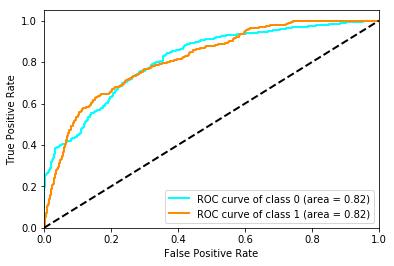

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.874040    0.562278     0.718159     0.804374      0.808217
precision     0.888137    0.532884     0.710510     0.804374      0.813132
recall        0.860383    0.595104     0.727743     0.804374      0.804374
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.815007    0.815007     0.815508     0.864920           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 195)
(12085, 2)
(2515, 195)
(2515, 2)
(12085, 8, 10)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

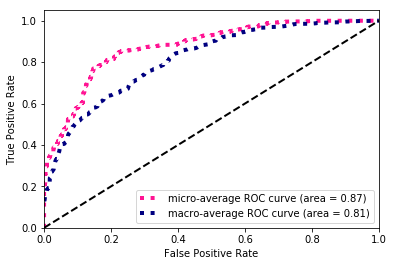

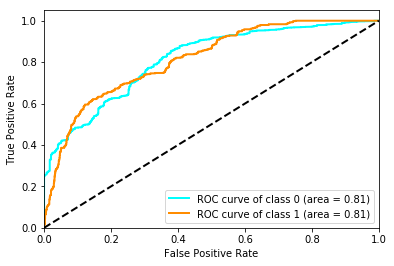

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.878509    0.571942     0.725226     0.810736      0.813783
precision     0.889866    0.547332     0.718599     0.810736      0.817545
recall        0.867440    0.598870     0.733155     0.810736      0.810736
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.813705    0.813704     0.814258     0.873854           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 195)
(12085, 2)
(2515, 195)
(2515, 2)
(12085, 8, 10)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

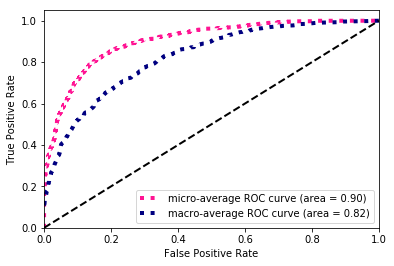

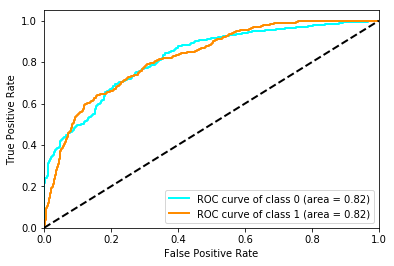

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.894507    0.526201     0.710354     0.827435      0.816745
precision     0.863850    0.625974     0.744912     0.827435      0.813626
recall        0.927419    0.453861     0.690640     0.827435      0.827435
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.822527    0.822527     0.823006     0.902581           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 171)
(12085, 2)
(2515, 171)
(2515, 2)
(12085, 8, 7)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

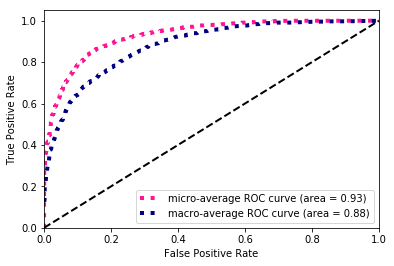

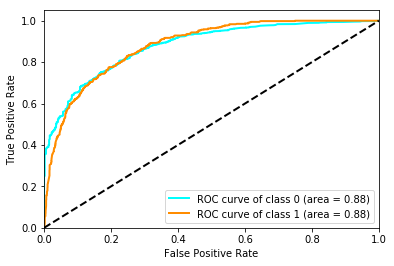

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910338    0.613924     0.762131     0.854473      0.847755
precision     0.885605    0.697842     0.791724     0.854473      0.845962
recall        0.936492    0.548023     0.742257     0.854473      0.854473
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.879885    0.879885     0.880113     0.928386           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 171)
(12085, 2)
(2515, 171)
(2515, 2)
(12085, 8, 7)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

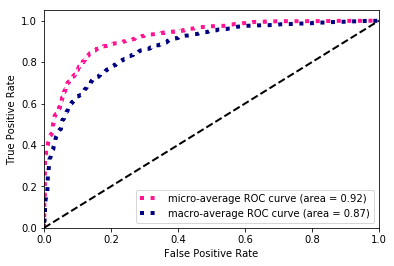

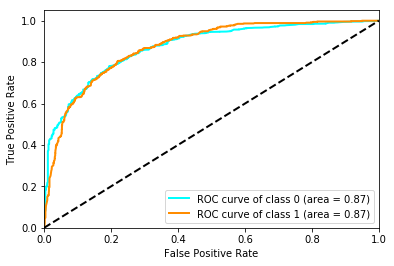

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.908776    0.625381     0.767078     0.853280      0.848942
precision     0.891800    0.678414     0.785107     0.853280      0.846747
recall        0.926411    0.580038     0.753224     0.853280      0.853280
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.872720    0.872720     0.873018     0.920419           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 171)
(12085, 2)
(2515, 171)
(2515, 2)
(12085, 8, 7)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

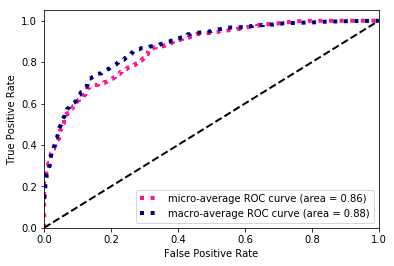

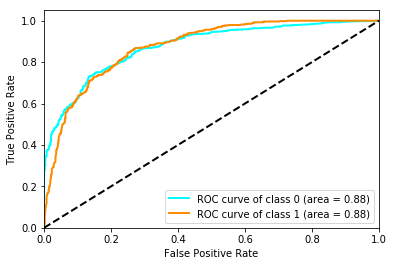

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.827488    0.602758     0.715123     0.759443      0.780040
precision     0.952725    0.462702     0.707713     0.759443      0.849265
recall        0.731351    0.864407     0.797879     0.759443      0.759443
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.875984    0.875984     0.876205     0.863310           NaN

In [16]:
Atlanta = compare_models(classname='RNN_embed')

In [17]:
Atlanta.to_hdf('Atlanta.h5',key='RNN_embed_only')
Atlanta

traffic   weather      time
0_f1-score              0.886339  0.882352  0.882201
1_f1-score              0.570723  0.553474  0.614021
weighted avg_f1-score   0.819702  0.812915  0.825579
micro avg_f1-score      0.820676  0.814182  0.822399
macro avg_f1-score      0.728531  0.717913  0.748111
0_precision             0.884997  0.880618  0.910043
1_precision             0.584602  0.568730  0.612986
weighted avg_precision  0.821574  0.814768  0.847325
micro avg_precision     0.820676  0.814182  0.822399
macro avg_precision     0.734800  0.724674  0.761515
0_recall                0.888777  0.885081  0.864751
1_recall                0.566227  0.549278  0.664156
weighted avg_recall     0.820676  0.814182  0.822399
micro avg_recall        0.820676  0.814182  0.822399
macro avg_recall        0.727502  0.717179  0.764454
0_auc                   0.823194  0.817080  0.876196
1_auc                   0.823195  0.817079  0.876196
micro avg_auc           0.887040  0.880451  0.904038
macro avg_auc           0.823495  0.817591  0.876445

# LosAngeles

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 100)
(30862, 2)
(6132, 100)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_143 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_67 (Batc (None, 256)               1024      
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)         

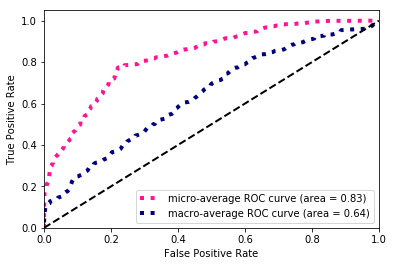

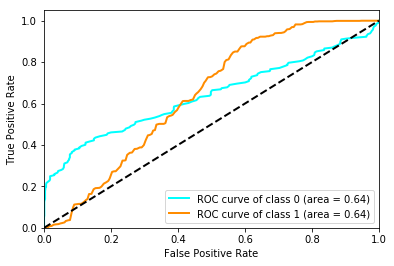

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.872747     0.002882     0.437815     0.774299      0.683085
precision     0.780464     0.039216     0.409840     0.774299      0.618845
recall        0.989781     0.001496     0.495638     0.774299      0.774299
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.639422     0.639422     0.639513     0.829349           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 100)
(30862, 2)
(6132, 100)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_147 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_69 (Batc (None, 256)               1024      
_________________________________________________________________
activation_69 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)         

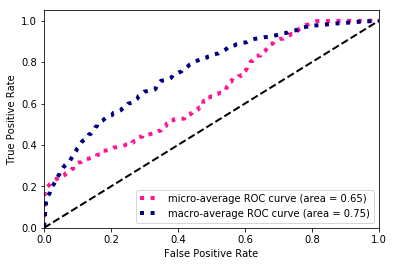

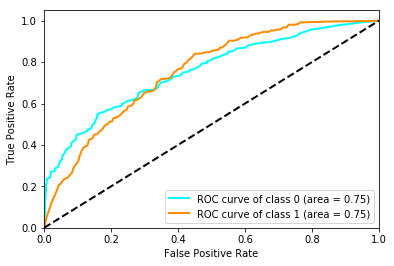

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.623927     0.461325     0.542626     0.557078      0.588474
precision     0.928307     0.313900     0.621103     0.557078      0.794344
recall        0.469864     0.869858     0.669861     0.557078      0.557078
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.753949     0.753949     0.754043     0.653126           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 100)
(30862, 2)
(6132, 100)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_151 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_71 (Batc (None, 256)               1024      
_________________________________________________________________
activation_71 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)         

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


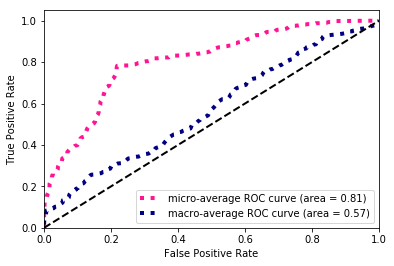

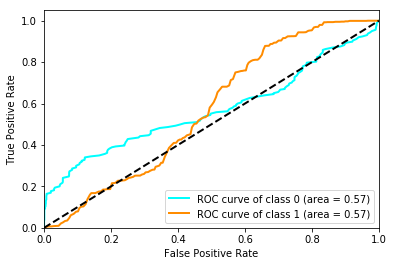

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.569863     0.569863     0.569960     0.805786           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 14)
(30862, 2)
(6132, 14)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_155 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
activation_73 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)           

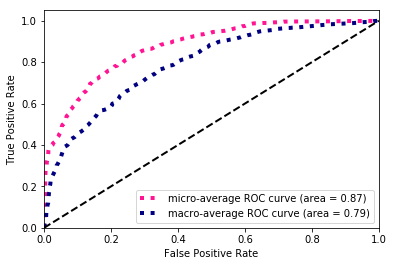

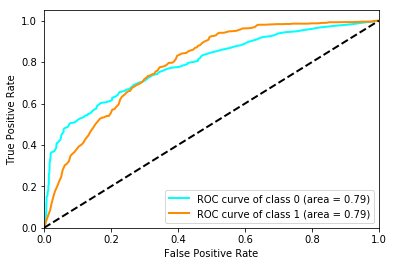

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.864563     0.445368     0.654965     0.782290      0.773163
precision     0.841762     0.500935     0.671348     0.782290      0.767449
recall        0.888634     0.400898     0.644766     0.782290      0.782290
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.789190     0.789190     0.789280     0.872314           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 14)
(30862, 2)
(6132, 14)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_159 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_75 (Batc (None, 256)               1024      
_________________________________________________________________
activation_75 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)           

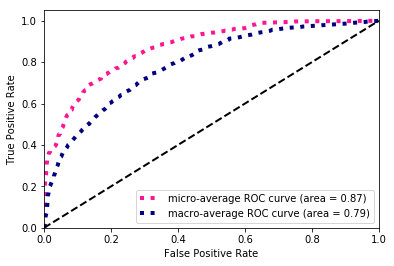

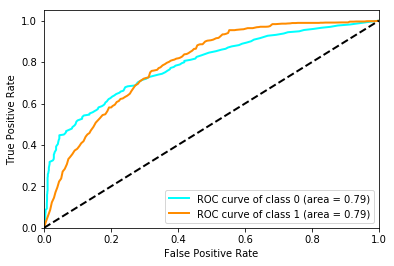

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.857734     0.470950     0.664342     0.775766      0.773401
precision     0.851129     0.484945     0.668037     0.775766      0.771288
recall        0.864442     0.457741     0.661092     0.775766      0.775766
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.789287     0.789287     0.789370     0.870016           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 14)
(30862, 2)
(6132, 14)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_163 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_________________________________________________________________
activation_77 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)           

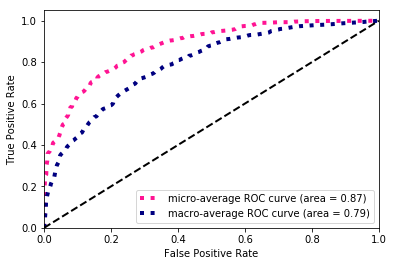

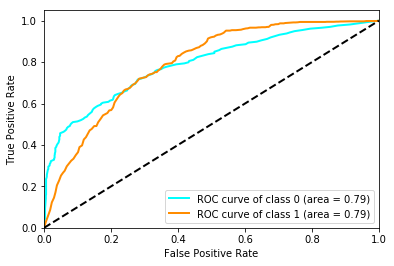

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.863506     0.460420     0.661963     0.782127      0.775619
precision     0.846385     0.500439     0.673412     0.782127      0.770956
recall        0.881335     0.426328     0.653831     0.782127      0.782127
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.790986     0.790986     0.791068     0.873732           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 64)
(30862, 2)
(6132, 64)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_167 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_79 (Batc (None, 256)               1024      
_________________________________________________________________
activation_79 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)           

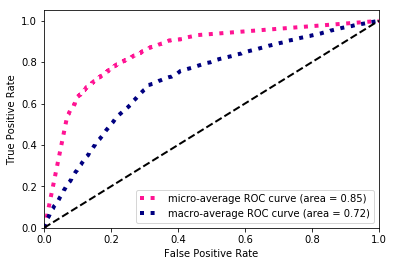

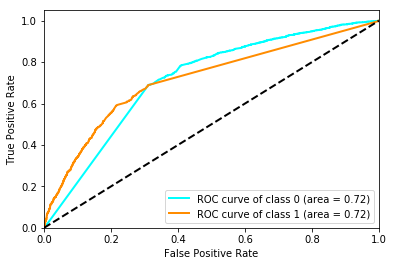

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.871500     0.346402     0.608951     0.785225      0.757009
precision     0.818849     0.514749     0.666799     0.785225      0.752544
recall        0.931387     0.261032     0.596210     0.785225      0.785225
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.715791     0.715791     0.715911     0.853129           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 64)
(30862, 2)
(6132, 64)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_170 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_171 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_81 (Batc (None, 256)               1024      
_________________________________________________________________
activation_81 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)           

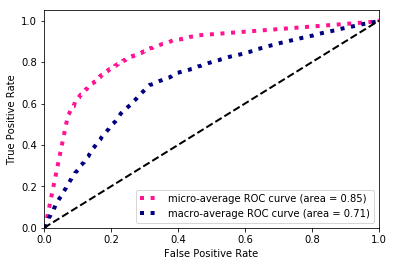

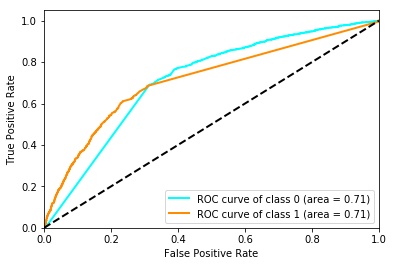

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.871720     0.331307     0.601514     0.784736      0.753890
precision     0.816197     0.513344     0.664770     0.784736      0.750164
recall        0.935349     0.244577     0.589963     0.784736      0.784736
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.712919     0.712919     0.713037     0.850965           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 64)
(30862, 2)
(6132, 64)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_175 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_________________________________________________________________
activation_83 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)           

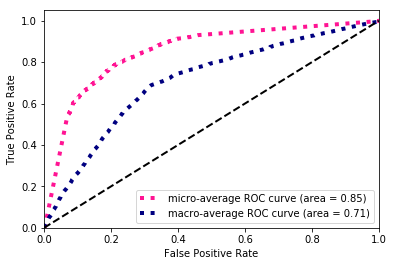

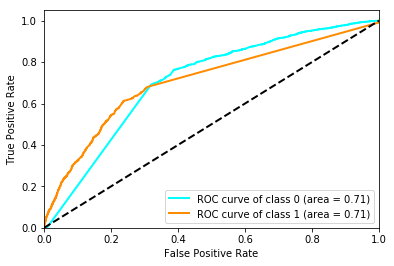

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.873559     0.328358     0.600958     0.787182      0.754685
precision     0.815780     0.526403     0.671091     0.787182      0.752685
recall        0.940146     0.238594     0.589370     0.787182      0.787182
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.707545     0.707545     0.707668     0.852047           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 80)
(30862, 2)
(6132, 80)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_178 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_179 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_85 (Batc (None, 256)               1024      
_________________________________________________________________
activation_85 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)           

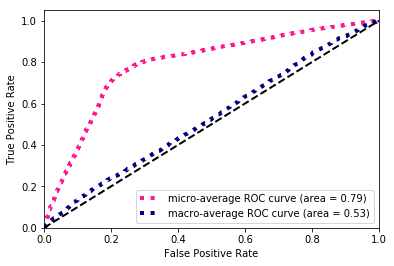

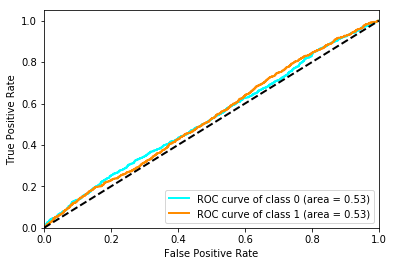

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.859917     0.102657     0.481287     0.757665      0.694807
precision     0.784621     0.266458     0.525539     0.757665      0.671642
recall        0.951199     0.063575     0.507387     0.757665      0.757665
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.529557     0.529557     0.529742     0.787910           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 80)
(30862, 2)
(6132, 80)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_183 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_87 (Batc (None, 256)               1024      
_________________________________________________________________
activation_87 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)           

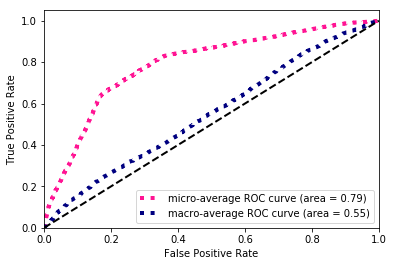

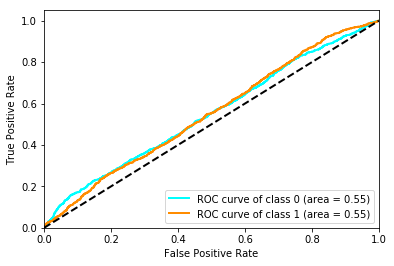

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.842769     0.167351     0.505060     0.735486      0.695503
precision     0.787357     0.266776     0.527067     0.735486      0.673852
recall        0.906569     0.121915     0.514242     0.735486      0.735486
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.550180     0.550180     0.550363     0.788998           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 80)
(30862, 2)
(6132, 80)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_187 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_89 (Batc (None, 256)               1024      
_________________________________________________________________
activation_89 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)           

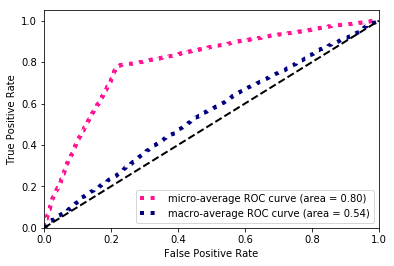

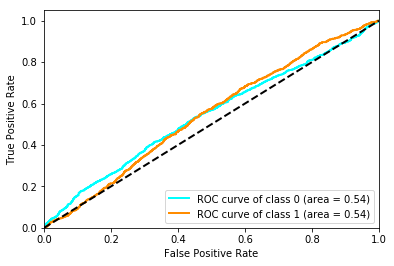

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.544234     0.544233     0.544425     0.797047           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 56)
(30862, 2)
(6132, 56)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_190 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_191 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_91 (Batc (None, 256)               1024      
_________________________________________________________________
activation_91 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)           

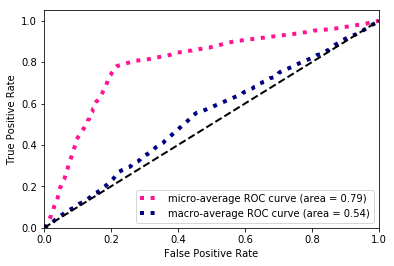

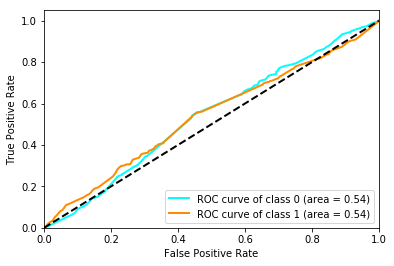

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.537751     0.537751     0.537771     0.794836           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 56)
(30862, 2)
(6132, 56)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_194 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_195 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_93 (Batc (None, 256)               1024      
_________________________________________________________________
activation_93 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)           

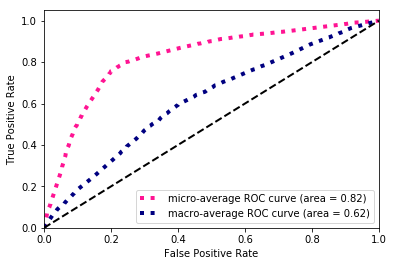

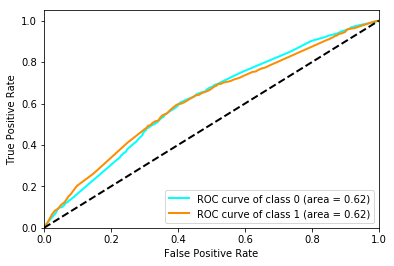

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.873676     0.092123     0.482900     0.778213      0.703269
precision     0.787640     0.428571     0.608106     0.778213      0.709350
recall        0.980813     0.051608     0.516211     0.778213      0.778213
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.615691     0.615691     0.615715     0.821199           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 56)
(30862, 2)
(6132, 56)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_199 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024      
_________________________________________________________________
activation_95 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)           

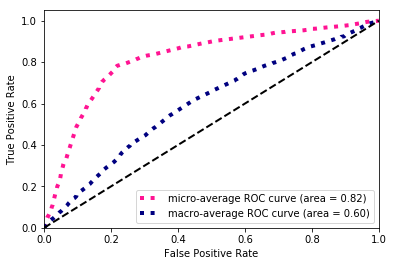

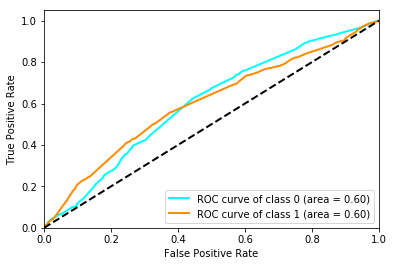

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.601071     0.601071     0.601082     0.816428           NaN

In [18]:
LosAngeles = compare_models(city='LosAngeles',classname='DNN')

In [19]:
LosAngeles.to_hdf('LosAngeles.h5',key='DNN_only')
LosAngeles

NL   geohash   traffic   weather      time
0_f1-score              0.791439  0.861935  0.872260  0.860109  0.876320
1_f1-score              0.154736  0.458913  0.335356  0.090003  0.030708
weighted avg_f1-score   0.652614  0.774061  0.755195  0.692198  0.691946
micro avg_f1-score      0.704447  0.780061  0.785714  0.758371  0.780713
macro avg_f1-score      0.473087  0.660424  0.603808  0.475056  0.453514
0_precision             0.830245  0.846425  0.816942  0.784647  0.783856
1_precision             0.117705  0.495439  0.518165  0.177744  0.142857
weighted avg_precision  0.674885  0.769898  0.751798  0.652320  0.644095
micro avg_precision     0.704447  0.780061  0.785714  0.758371  0.780713
macro avg_precision     0.473975  0.670932  0.667553  0.481196  0.463356
0_recall                0.819882  0.878137  0.935627  0.952590  0.993604
1_recall                0.290451  0.428322  0.248068  0.061830  0.017203
weighted avg_recall     0.704447  0.780061  0.785714  0.758371  0.780713
micro avg_recall        0.704447  0.780061  0.785714  0.758371  0.780713
macro avg_recall        0.555167  0.653230  0.591848  0.507210  0.505404
0_auc                   0.654412  0.789821  0.712085  0.541323  0.584838
1_auc                   0.654412  0.789821  0.712085  0.541323  0.584838
micro avg_auc           0.762754  0.872021  0.852047  0.791319  0.810821
macro avg_auc           0.654505  0.789906  0.712206  0.541510  0.584856

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 178)
(30862, 2)
(6132, 178)
(6132, 2)
(30862, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_38 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_202 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_203 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

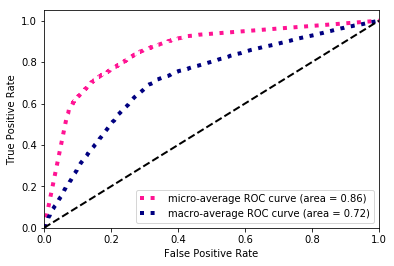

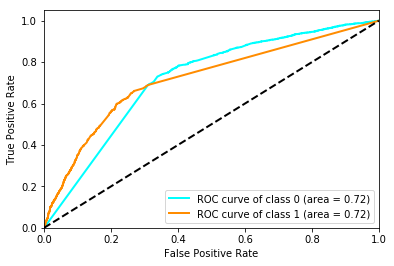

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.869344     0.350536     0.609940     0.782453      0.756225
precision     0.819575     0.502092     0.660834     0.782453      0.750352
recall        0.925547     0.269260     0.597403     0.782453      0.782453
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.717513     0.717513     0.717642     0.855361           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 178)
(30862, 2)
(6132, 178)
(6132, 2)
(30862, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_40 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_206 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_207 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

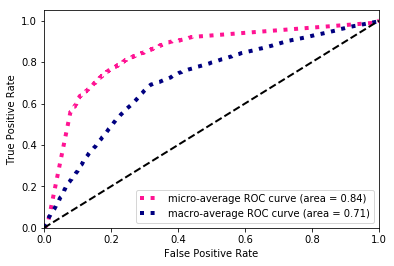

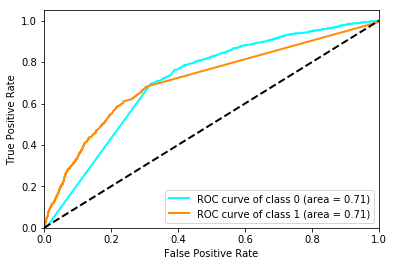

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.867742     0.379582     0.623662     0.781963      0.761305
precision     0.825367     0.500000     0.662683     0.781963      0.754425
recall        0.914703     0.305909     0.610306     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.711977     0.711977     0.712089     0.843149           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 178)
(30862, 2)
(6132, 178)
(6132, 2)
(30862, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_42 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_210 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_211 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

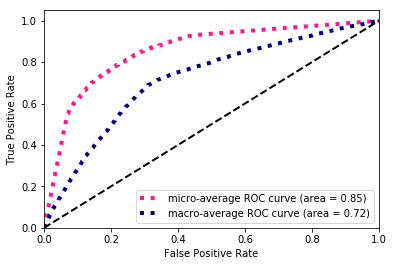

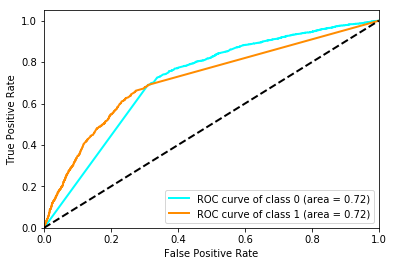

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.870247     0.357282     0.613764     0.784083      0.758402
precision     0.820854     0.508990     0.664922     0.784083      0.752856
recall        0.925965     0.275243     0.600604     0.784083      0.784083
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.716733     0.716733     0.716850     0.854097           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 194)
(30862, 2)
(6132, 194)
(6132, 2)
(30862, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_214 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_215 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


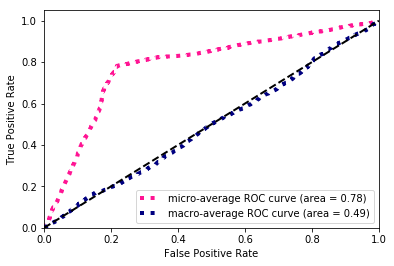

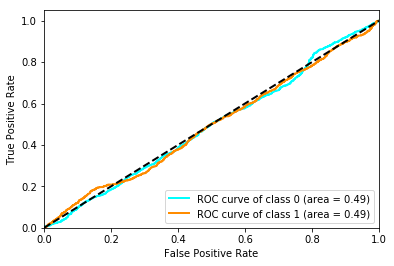

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.493134     0.493134     0.493250     0.779622           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 194)
(30862, 2)
(6132, 194)
(6132, 2)
(30862, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_46 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_218 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_219 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

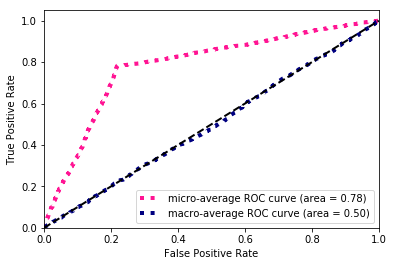

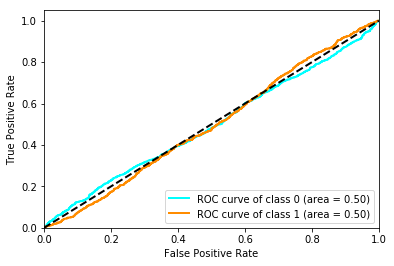

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.877643     0.00000     0.438821     0.781963      0.686284
precision     0.781963     0.00000     0.390982     0.781963      0.611467
recall        1.000000     0.00000     0.500000     0.781963      0.781963
support    4795.000000  1337.00000  6132.000000  6132.000000   6132.000000
auc           0.495920     0.49592     0.496081     0.780572           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 194)
(30862, 2)
(6132, 194)
(6132, 2)
(30862, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_48 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_222 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_223 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

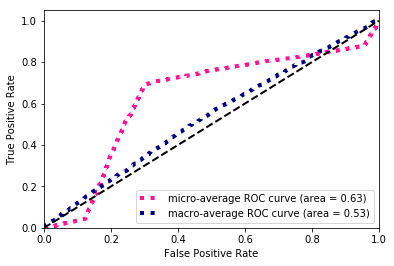

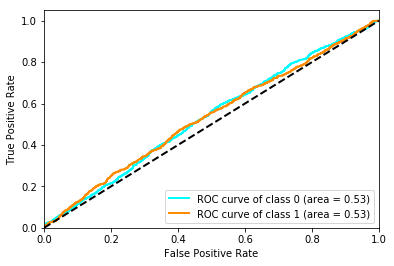

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.809766     0.231717     0.520742     0.695042      0.683730
precision     0.790467     0.257065     0.523766     0.695042      0.674166
recall        0.830031     0.210920     0.520476     0.695042      0.695042
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.534146     0.534146     0.534340     0.630089           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 170)
(30862, 2)
(6132, 170)
(6132, 2)
(30862, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_50 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_226 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_227 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

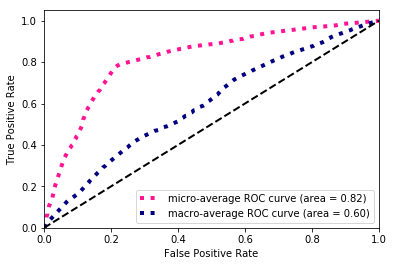

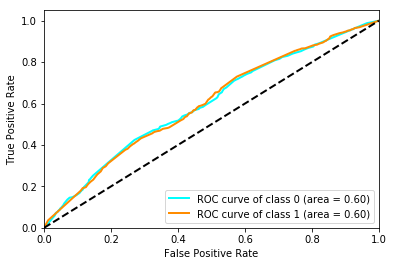

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.597783     0.597783     0.597803     0.815307           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 170)
(30862, 2)
(6132, 170)
(6132, 2)
(30862, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_52 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_230 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_231 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

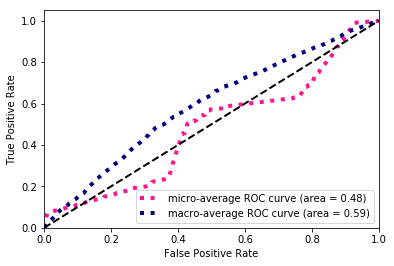

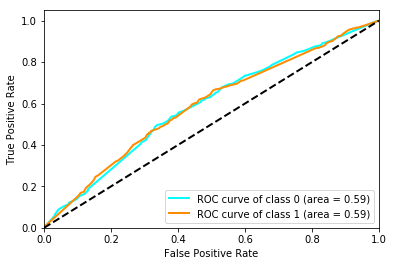

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.633364     0.375579     0.504471     0.537997      0.577157
precision     0.834584     0.266250     0.550417     0.537997      0.710666
recall        0.510323     0.637248     0.573785     0.537997      0.537997
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.589667     0.589667     0.589694     0.479855           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 170)
(30862, 2)
(6132, 170)
(6132, 2)
(30862, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_54 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_234 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_235 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

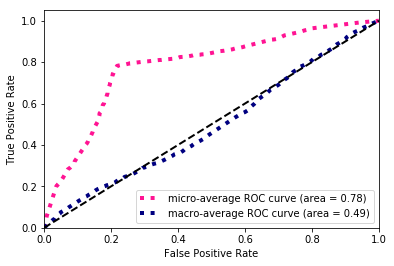

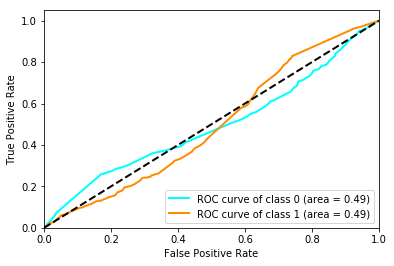

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.493629     0.493629     0.493649     0.779791           NaN

In [20]:
LosAngeles = compare_models(city='LosAngeles',classname='RNN')

In [21]:
LosAngeles.to_hdf('LosAngeles.h5',key='RNN_only')
LosAngeles

traffic   weather      time
0_f1-score              0.869111  0.855017  0.796216
1_f1-score              0.362466  0.077239  0.125193
weighted avg_f1-score   0.758644  0.685433  0.649909
micro avg_f1-score      0.782833  0.752990  0.700641
macro avg_f1-score      0.615789  0.466128  0.460705
0_precision             0.821932  0.784798  0.799504
1_precision             0.503694  0.085688  0.088750
weighted avg_precision  0.752545  0.632366  0.644533
micro avg_precision     0.782833  0.752990  0.700641
macro avg_precision     0.662813  0.435243  0.444127
0_recall                0.922072  0.943344  0.836774
1_recall                0.283470  0.070307  0.212416
weighted avg_recall     0.782833  0.752990  0.700641
micro avg_recall        0.782833  0.752990  0.700641
macro avg_recall        0.602771  0.506825  0.524595
0_auc                   0.715408  0.507733  0.560360
1_auc                   0.715408  0.507733  0.560360
micro avg_auc           0.850869  0.730094  0.691651
macro avg_auc           0.715527  0.507890  0.560382

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 179)
(30862, 2)
(6132, 179)
(6132, 2)
(30862, 8, 8)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

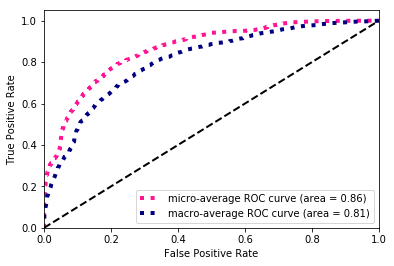

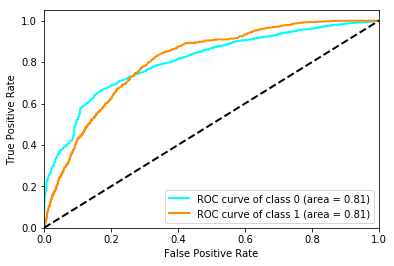

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.862548     0.512421     0.687485     0.785551      0.786208
precision     0.864627     0.508088     0.686358     0.785551      0.786889
recall        0.860480     0.516829     0.688654     0.785551      0.785551
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.806070     0.806070     0.806206     0.863139           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 179)
(30862, 2)
(6132, 179)
(6132, 2)
(30862, 8, 8)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

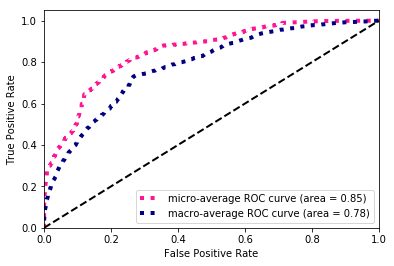

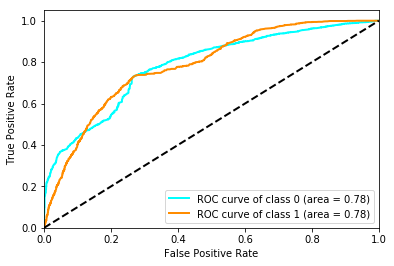

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.855046     0.523593     0.689320     0.777723      0.782777
precision     0.872396     0.491470     0.681933     0.777723      0.789340
recall        0.838373     0.560209     0.699291     0.777723      0.777723
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.783060     0.783060     0.783196     0.850872           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 179)
(30862, 2)
(6132, 179)
(6132, 2)
(30862, 8, 8)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

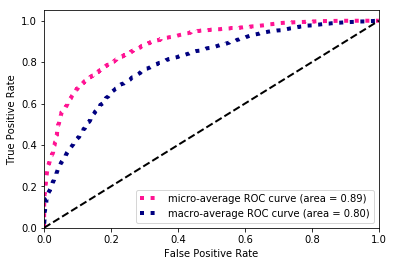

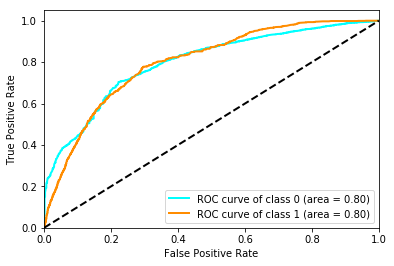

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.878628     0.376376     0.627502     0.796804      0.769119
precision     0.824347     0.568835     0.696591     0.796804      0.768636
recall        0.940563     0.281227     0.610895     0.796804      0.796804
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.797633     0.797633     0.797769     0.885416           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 195)
(30862, 2)
(6132, 195)
(6132, 2)
(30862, 8, 10)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

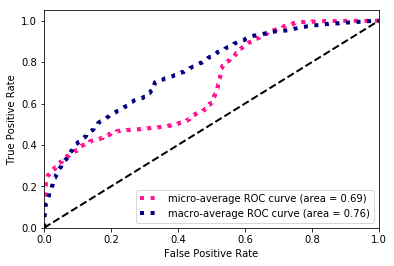

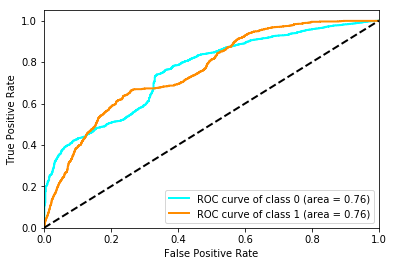

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.615577     0.452875     0.534226     0.548434      0.580102
precision     0.920681     0.307734     0.614207     0.548434      0.787036
recall        0.462357     0.857143     0.659750     0.548434      0.548434
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.757896     0.757895     0.758105     0.692212           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 195)
(30862, 2)
(6132, 195)
(6132, 2)
(30862, 8, 10)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

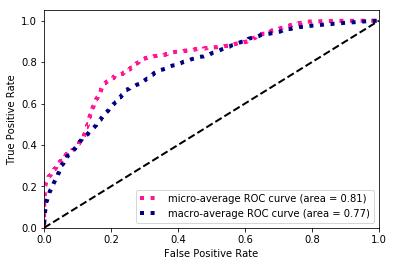

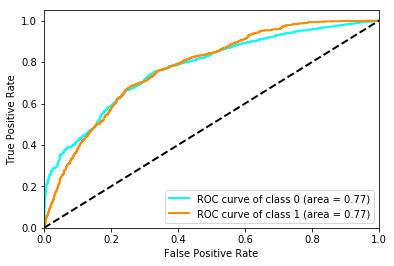

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.840465     0.483235     0.661850     0.756197      0.762576
precision     0.860577     0.449229     0.654903     0.756197      0.770888
recall        0.821272     0.522812     0.672042     0.756197      0.756197
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.773796     0.773797     0.774007     0.814246           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 195)
(30862, 2)
(6132, 195)
(6132, 2)
(30862, 8, 10)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


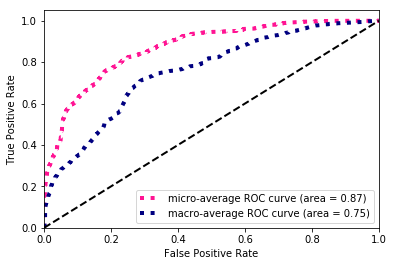

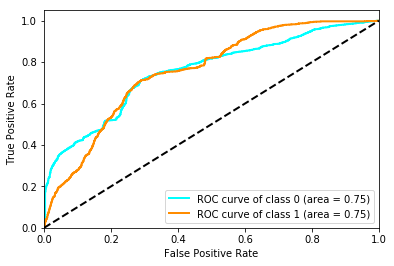

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.877643     0.000000     0.438821     0.781963      0.686284
precision     0.781963     0.000000     0.390982     0.781963      0.611467
recall        1.000000     0.000000     0.500000     0.781963      0.781963
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.754557     0.754557     0.754763     0.868766           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 171)
(30862, 2)
(6132, 171)
(6132, 2)
(30862, 8, 7)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

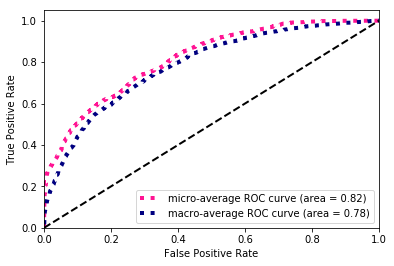

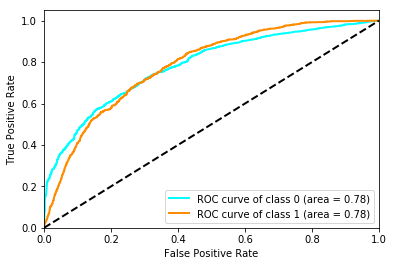

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.808787     0.516964     0.662875     0.726027      0.745159
precision     0.890253     0.419897     0.655075     0.726027      0.787698
recall        0.740980     0.672401     0.706691     0.726027      0.726027
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.784165     0.784165     0.784268     0.817226           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 171)
(30862, 2)
(6132, 171)
(6132, 2)
(30862, 8, 7)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

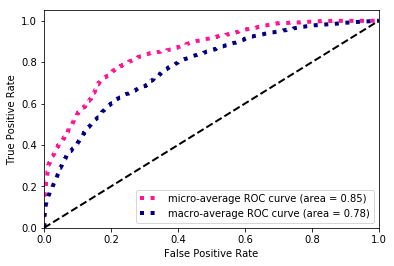

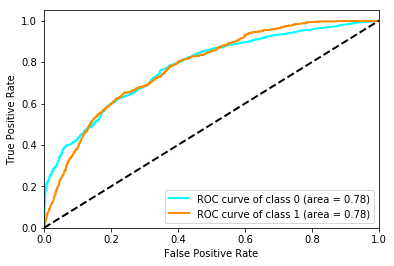

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.854723     0.513475     0.684099     0.776256      0.780318
precision     0.868144     0.488200     0.678172     0.776256      0.785302
recall        0.841710     0.541511     0.691610     0.776256      0.776256
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.776877     0.776877     0.776985     0.850056           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 171)
(30862, 2)
(6132, 171)
(6132, 2)
(30862, 8, 7)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

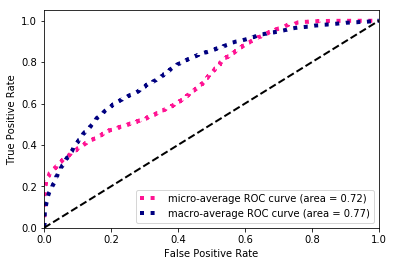

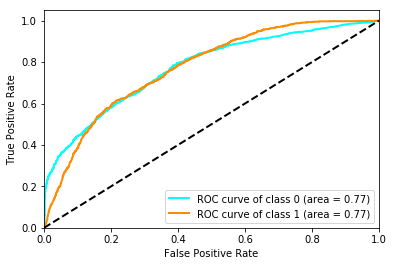

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.679389     0.477925     0.578657     0.602740      0.635463
precision     0.920799     0.334935     0.627867     0.602740      0.793059
recall        0.538269     0.833957     0.686113     0.602740      0.602740
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.773019     0.773019     0.773137     0.720269           NaN

In [22]:
LosAngeles = compare_models(city='LosAngeles',classname='RNN_embed')

In [23]:
LosAngeles.to_hdf('LosAngeles.h5',key='RNN_embed_only')
LosAngeles

traffic   weather      time
0_f1-score              0.865408  0.777895  0.780966
1_f1-score              0.470797  0.312037  0.502788
weighted avg_f1-score   0.779368  0.676321  0.720313
micro avg_f1-score      0.786693  0.695532  0.701674
macro avg_f1-score      0.668102  0.544966  0.641877
0_precision             0.853790  0.854407  0.893065
1_precision             0.522798  0.252321  0.414344
weighted avg_precision  0.781621  0.723130  0.788687
micro avg_precision     0.786693  0.695532  0.701674
macro avg_precision     0.688294  0.553364  0.653705
0_recall                0.879805  0.761210  0.706986
1_recall                0.452755  0.459985  0.682623
weighted avg_recall     0.786693  0.695532  0.701674
micro avg_recall        0.786693  0.695532  0.701674
macro avg_recall        0.666280  0.610597  0.694805
0_auc                   0.795587  0.762083  0.778020
1_auc                   0.795587  0.762083  0.778020
micro avg_auc           0.866476  0.791741  0.795850
macro avg_auc           0.795724  0.762292  0.778130

# Austin

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 100)
(22890, 2)
(4664, 100)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_283 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_284 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_133 (Bat (None, 256)               1024      
_________________________________________________________________
activation_133 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)         

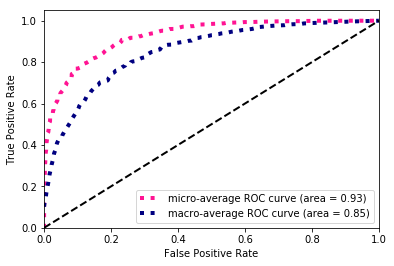

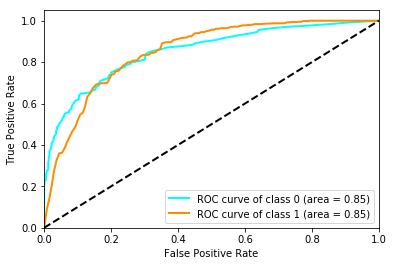

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.899909    0.518380     0.709145     0.834262      0.834385
precision     0.900259    0.517413     0.708836     0.834262      0.834509
recall        0.899560    0.519351     0.709455     0.834262      0.834262
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.851792    0.851792     0.851943     0.925514           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 100)
(22890, 2)
(4664, 100)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_287 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_288 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_135 (Bat (None, 256)               1024      
_________________________________________________________________
activation_135 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)         

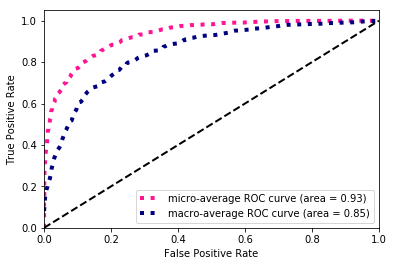

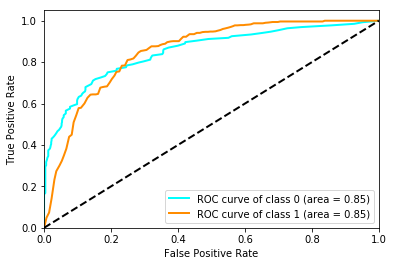

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.903160    0.486486     0.694823     0.837050      0.831600
precision     0.889335    0.530191     0.709763     0.837050      0.827655
recall        0.917422    0.449438     0.683430     0.837050      0.837050
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.850752    0.850752     0.850958     0.929058           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 100)
(22890, 2)
(4664, 100)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_291 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_292 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_137 (Bat (None, 256)               1024      
_________________________________________________________________
activation_137 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)         

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


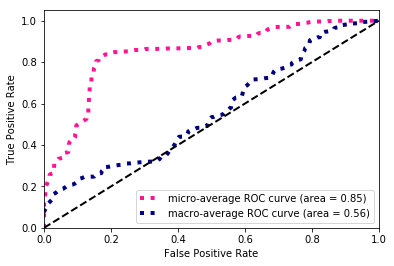

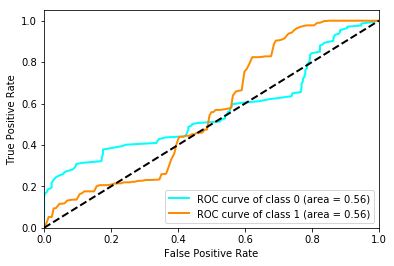

0          1    macro avg    micro avg  weighted avg
index                                                                    
f1-score      0.906063    0.00000     0.453032     0.828259      0.750455
precision     0.828259    0.00000     0.414130     0.828259      0.686013
recall        1.000000    0.00000     0.500000     0.828259      0.828259
support    3863.000000  801.00000  4664.000000  4664.000000   4664.000000
auc           0.562750    0.56275     0.562961     0.846111           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 14)
(22890, 2)
(4664, 14)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_295 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_296 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_139 (Bat (None, 256)               1024      
_________________________________________________________________
activation_139 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)           

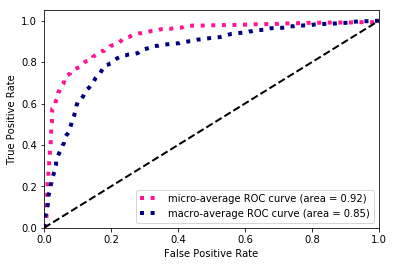

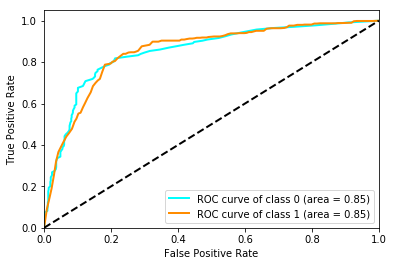

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.902742    0.528822     0.715782     0.838765      0.838524
precision     0.902042    0.530818     0.716430     0.838765      0.838287
recall        0.903443    0.526841     0.715142     0.838765      0.838765
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.852107    0.852107     0.852347     0.919385           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 14)
(22890, 2)
(4664, 14)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_299 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_300 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_141 (Bat (None, 256)               1024      
_________________________________________________________________
activation_141 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)           

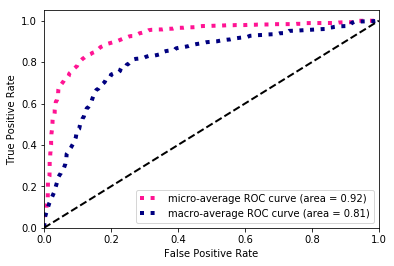

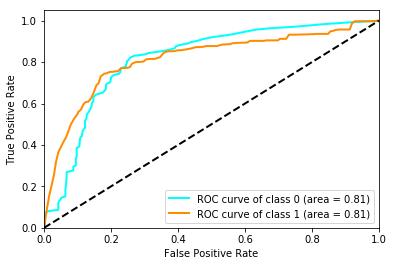

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910951    0.500354     0.705653     0.848842      0.840435
precision     0.889492    0.578689     0.734090     0.848842      0.836114
recall        0.933471    0.440699     0.687085     0.848842      0.848842
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.814537    0.814537     0.814893     0.920792           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 14)
(22890, 2)
(4664, 14)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_303 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_304 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_143 (Bat (None, 256)               1024      
_________________________________________________________________
activation_143 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 256)           

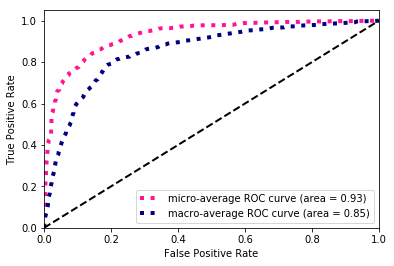

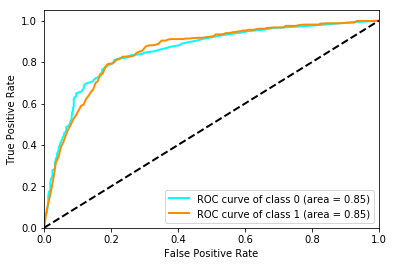

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.909184    0.529801     0.719493     0.847770      0.844028
precision     0.898609    0.564175     0.731392     0.847770      0.841173
recall        0.920010    0.499376     0.709693     0.847770      0.847770
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.853101    0.853101     0.853301     0.927498           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 64)
(22890, 2)
(4664, 64)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_308 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_145 (Bat (None, 256)               1024      
_________________________________________________________________
activation_145 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)           

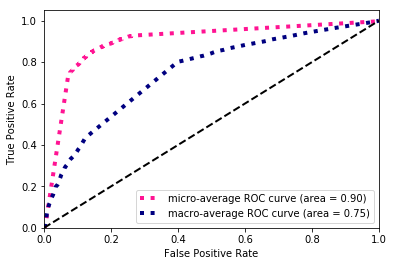

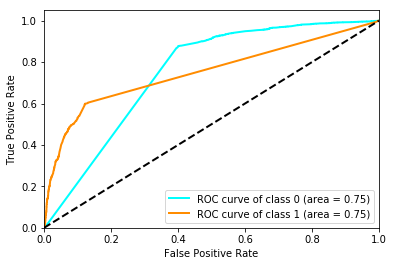

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.913795    0.513879     0.713837     0.853559      0.845113
precision     0.891626    0.597682     0.744654     0.853559      0.841143
recall        0.937096    0.450687     0.693891     0.853559      0.853559
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.749572    0.749572     0.749658     0.898677           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 64)
(22890, 2)
(4664, 64)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_312 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_147 (Bat (None, 256)               1024      
_________________________________________________________________
activation_147 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)           

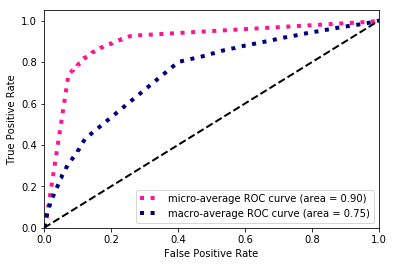

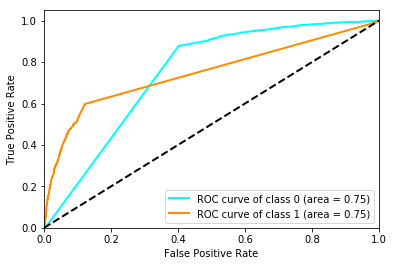

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.913239    0.467075     0.690157     0.850772      0.836614
precision     0.880741    0.603960     0.742350     0.850772      0.833206
recall        0.948227    0.380774     0.664500     0.850772      0.850772
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.746545    0.746545     0.746692     0.897776           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 64)
(22890, 2)
(4664, 64)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_315 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_316 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_149 (Bat (None, 256)               1024      
_________________________________________________________________
activation_149 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)           

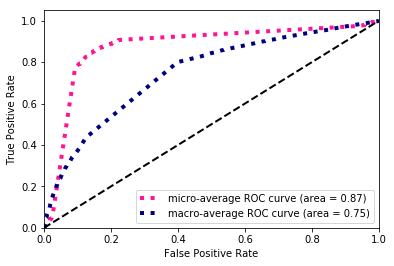

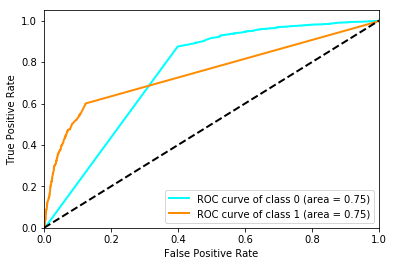

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.913164    0.500724     0.706944     0.852058      0.842331
precision     0.888562    0.595525     0.742044     0.852058      0.838236
recall        0.939166    0.431960     0.685563     0.852058      0.852058
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.748330    0.748330     0.748445     0.873740           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 80)
(22890, 2)
(4664, 80)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_319 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_320 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_151 (Bat (None, 256)               1024      
_________________________________________________________________
activation_151 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 256)           

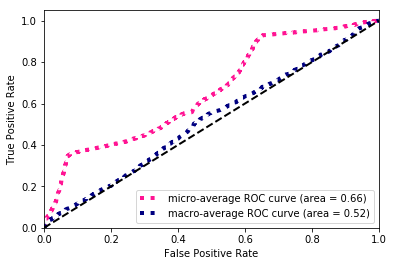

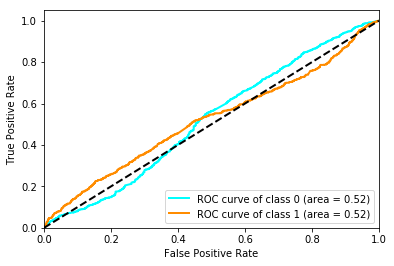

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.682897    0.274841     0.478869     0.558748      0.612817
precision     0.843548    0.191458     0.517503     0.558748      0.731557
recall        0.573647    0.486891     0.530269     0.558748      0.558748
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.520666    0.520666     0.520880     0.659279           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 80)
(22890, 2)
(4664, 80)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_323 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_324 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_153 (Bat (None, 256)               1024      
_________________________________________________________________
activation_153 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)           

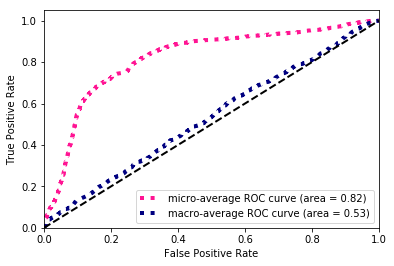

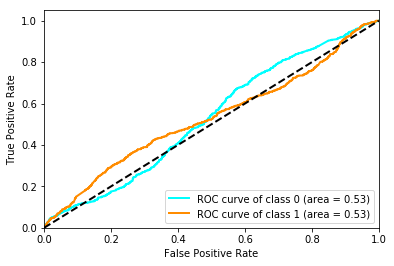

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.854315    0.207182     0.530749     0.753859      0.743176
precision     0.837939    0.231839     0.534889     0.753859      0.733847
recall        0.871344    0.187266     0.529305     0.753859      0.753859
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.530504    0.530504     0.530708     0.818671           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 80)
(22890, 2)
(4664, 80)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_327 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_328 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_155 (Bat (None, 256)               1024      
_________________________________________________________________
activation_155 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)           

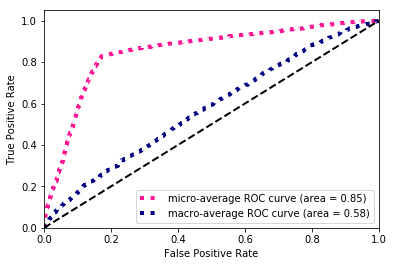

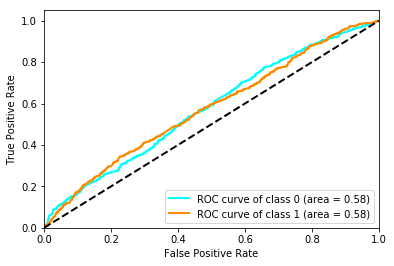

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.575399    0.575399     0.575616     0.849710           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 56)
(22890, 2)
(4664, 56)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_331 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_332 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_157 (Bat (None, 256)               1024      
_________________________________________________________________
activation_157 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)           

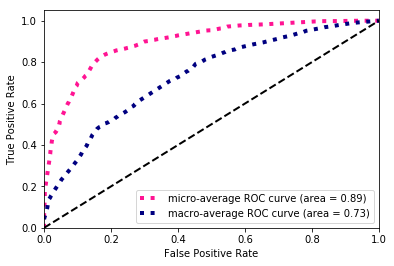

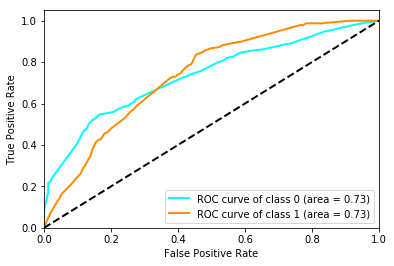

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.734012    0.734012     0.734069     0.894833           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 56)
(22890, 2)
(4664, 56)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_335 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_336 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_159 (Bat (None, 256)               1024      
_________________________________________________________________
activation_159 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)           

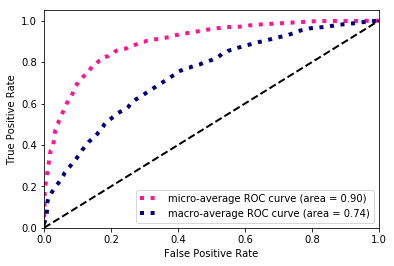

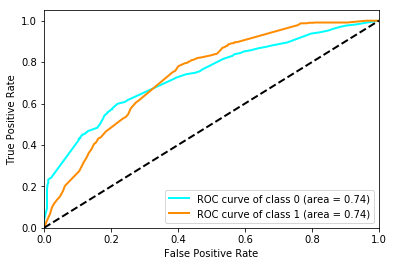

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.900469    0.188420     0.544445     0.822684      0.778181
precision     0.841430    0.440367     0.640899     0.822684      0.772551
recall        0.968418    0.119850     0.544134     0.822684      0.822684
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.738952    0.738952     0.738999     0.895120           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 56)
(22890, 2)
(4664, 56)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_339 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_340 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_161 (Bat (None, 256)               1024      
_________________________________________________________________
activation_161 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)           

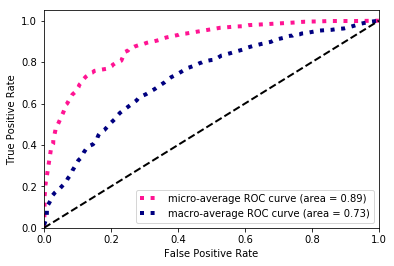

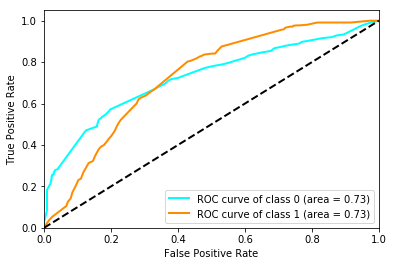

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880383    0.171623     0.526003     0.790952      0.758660
precision     0.836754    0.268617     0.552685     0.790952      0.739181
recall        0.928812    0.126092     0.527452     0.790952      0.790952
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.726603    0.726603     0.726660     0.887985           NaN

In [24]:
Austin = compare_models(city='Austin',classname='DNN')

In [25]:
Austin.to_hdf('Austin.h5',key='DNN_only')
Austin

NL   geohash   traffic   weather      time
0_f1-score              0.903044  0.907626  0.913399  0.814425  0.895638
1_f1-score              0.334956  0.519659  0.493893  0.160675  0.120014
weighted avg_f1-score   0.805480  0.840996  0.841353  0.702149  0.762432
micro avg_f1-score      0.833190  0.845126  0.852130  0.713622  0.813965
macro avg_f1-score      0.619000  0.713642  0.703646  0.487550  0.507826
0_precision             0.872618  0.896714  0.886976  0.836582  0.835481
1_precision             0.349201  0.557894  0.599056  0.141099  0.236328
weighted avg_precision  0.782726  0.838525  0.837528  0.717139  0.732582
micro avg_precision     0.833190  0.845126  0.852130  0.713622  0.813965
macro avg_precision     0.610910  0.727304  0.743016  0.488840  0.535905
0_recall                0.938994  0.918975  0.941496  0.814997  0.965743
1_recall                0.322930  0.488972  0.421140  0.224719  0.081981
weighted avg_recall     0.833190  0.845126  0.852130  0.713622  0.813965
micro avg_recall        0.833190  0.845126  0.852130  0.713622  0.813965
macro avg_recall        0.630962  0.703974  0.681318  0.519858  0.523862
0_auc                   0.755098  0.839915  0.748149  0.542190  0.733189
1_auc                   0.755098  0.839915  0.748149  0.542190  0.733189
micro avg_auc           0.900228  0.922558  0.890064  0.775886  0.892646
macro avg_auc           0.755287  0.840180  0.748265  0.542401  0.733243

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 178)
(22890, 2)
(4664, 178)
(4664, 2)
(22890, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_74 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_343 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_344 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

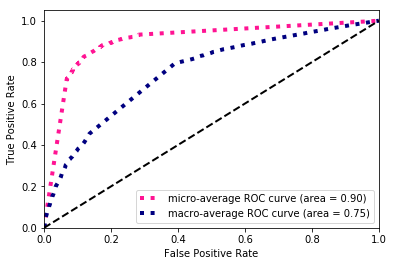

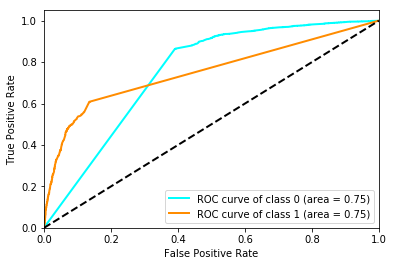

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.913611    0.495601     0.704606     0.852487      0.841822
precision     0.887101    0.600355     0.743728     0.852487      0.837855
recall        0.941755    0.421973     0.681864     0.852487      0.852487
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.750986    0.750986     0.751123     0.902921           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 178)
(22890, 2)
(4664, 178)
(4664, 2)
(22890, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_76 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_347 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_348 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

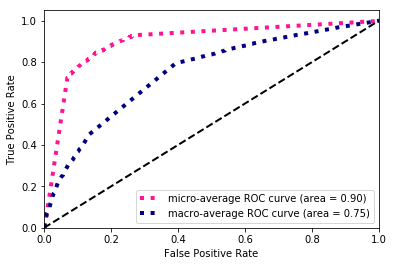

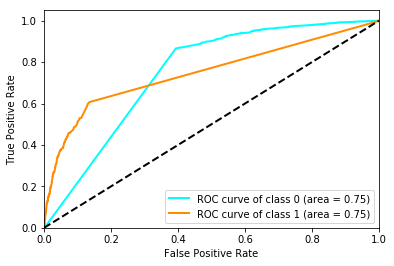

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.908560    0.504814     0.706687     0.845626      0.839220
precision     0.891798    0.562021     0.726909     0.845626      0.835161
recall        0.925964    0.458177     0.692071     0.845626      0.845626
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.747571    0.747571     0.747704     0.898174           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 178)
(22890, 2)
(4664, 178)
(4664, 2)
(22890, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_78 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_351 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_352 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

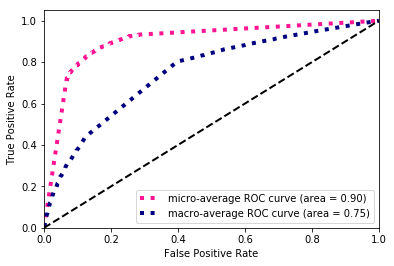

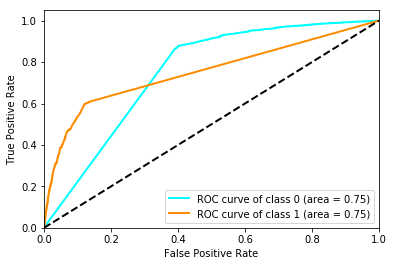

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.912409    0.496382     0.704395     0.850772      0.840960
precision     0.887828    0.590361     0.739095     0.850772      0.836740
recall        0.938390    0.428215     0.683302     0.850772      0.850772
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.751372    0.751372     0.751447     0.902737           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 194)
(22890, 2)
(4664, 194)
(4664, 2)
(22890, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_80 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_355 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_356 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


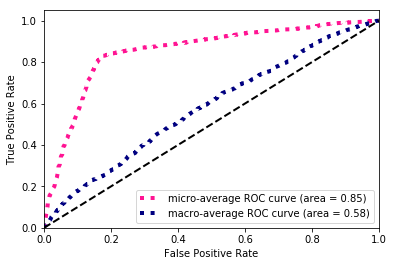

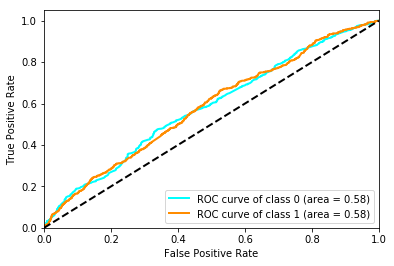

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.581614    0.581623     0.581719     0.851479           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 194)
(22890, 2)
(4664, 194)
(4664, 2)
(22890, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_82 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_359 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_360 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

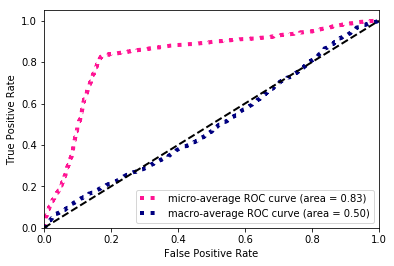

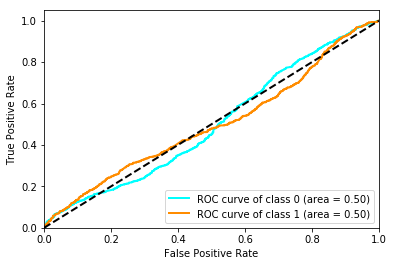

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.499699    0.499699     0.499903     0.828173           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 194)
(22890, 2)
(4664, 194)
(4664, 2)
(22890, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_84 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_363 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_364 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

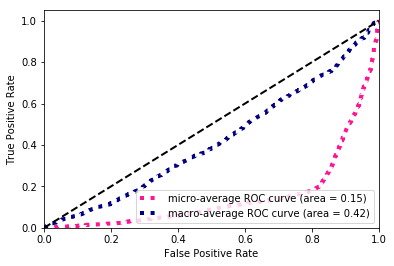

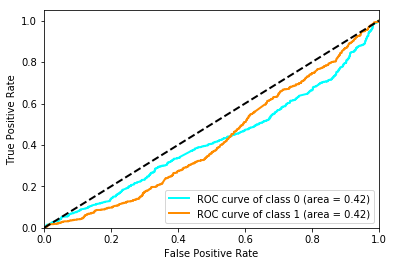

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.053594    0.291659     0.172626     0.189751      0.094479
precision     0.823077    0.171592     0.497335     0.189751      0.711190
recall        0.027699    0.971286     0.499492     0.189751      0.189751
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.420396    0.420396     0.420558     0.152048           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 170)
(22890, 2)
(4664, 170)
(4664, 2)
(22890, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_86 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_367 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_368 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

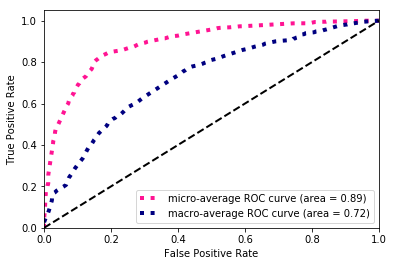

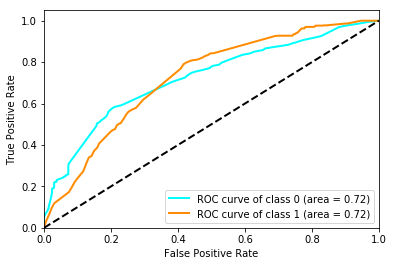

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.723537    0.723537     0.723658     0.891854           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 170)
(22890, 2)
(4664, 170)
(4664, 2)
(22890, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_88 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_371 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_372 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

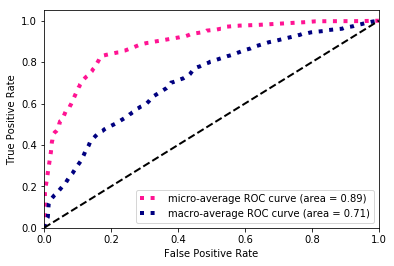

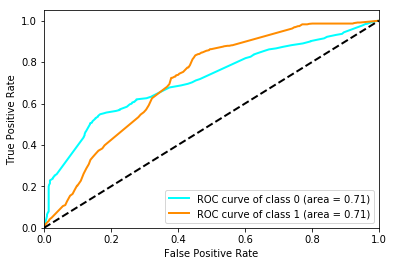

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.714294    0.714294     0.714425     0.889224           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 170)
(22890, 2)
(4664, 170)
(4664, 2)
(22890, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_90 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_375 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_376 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

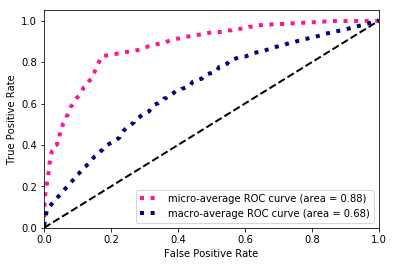

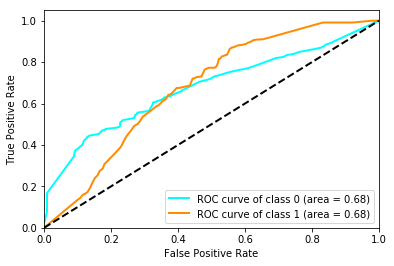

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906063    0.000000     0.453032     0.828259      0.750455
precision     0.828259    0.000000     0.414130     0.828259      0.686013
recall        1.000000    0.000000     0.500000     0.828259      0.828259
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.676018    0.676018     0.676397     0.878335           NaN

In [26]:
Austin = compare_models(city='Austin',classname='RNN')

In [27]:
Austin.to_hdf('Austin.h5',key='RNN_only')
Austin

traffic   weather      time
0_f1-score              0.911527  0.621907  0.906063
1_f1-score              0.498933  0.097220  0.000000
weighted avg_f1-score   0.840667  0.531796  0.750455
micro avg_f1-score      0.849628  0.615423  0.828259
macro avg_f1-score      0.705230  0.359563  0.453032
0_precision             0.888909  0.826532  0.828259
1_precision             0.584246  0.057197  0.000000
weighted avg_precision  0.836586  0.694405  0.686013
micro avg_precision     0.849628  0.615423  0.828259
macro avg_precision     0.736577  0.441865  0.414130
0_recall                0.935370  0.675900  1.000000
1_recall                0.436122  0.323762  0.000000
weighted avg_recall     0.849628  0.615423  0.828259
micro avg_recall        0.849628  0.615423  0.828259
macro avg_recall        0.685746  0.499831  0.500000
0_auc                   0.749976  0.500569  0.704616
1_auc                   0.749976  0.500573  0.704616
micro avg_auc           0.901277  0.610567  0.886471
macro avg_auc           0.750091  0.500727  0.704827

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 179)
(22890, 2)
(4664, 179)
(4664, 2)
(22890, 8, 8)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

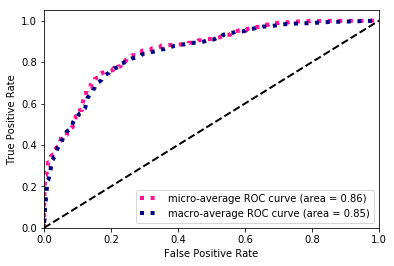

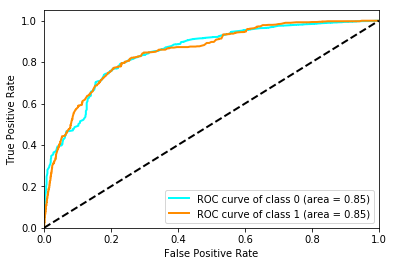

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.853738    0.547609     0.700673     0.778945      0.801163
precision     0.944444    0.422192     0.683318     0.778945      0.854752
recall        0.778928    0.779026     0.778977     0.778945      0.778945
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.848090    0.848090     0.848271     0.858319           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 179)
(22890, 2)
(4664, 179)
(4664, 2)
(22890, 8, 8)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

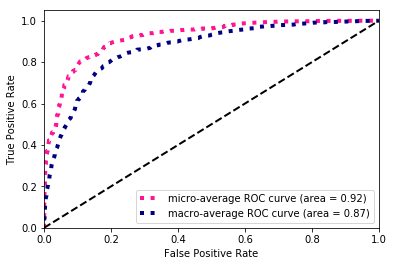

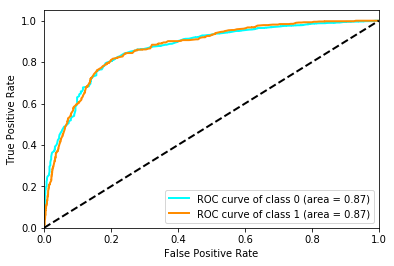

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.901128    0.584495     0.742812     0.840266      0.846749
precision     0.924564    0.528226     0.726395     0.840266      0.856497
recall        0.878851    0.654182     0.766516     0.840266      0.840266
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.866639    0.866639     0.866812     0.920489           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 179)
(22890, 2)
(4664, 179)
(4664, 2)
(22890, 8, 8)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

Epoch 44/60
 - 3s - loss: 0.3221 - f1_score: 0.4710 - val_loss: 0.2236 - val_f1_score: 0.2760
Epoch 45/60
 - 3s - loss: 0.3208 - f1_score: 0.4751 - val_loss: 0.2241 - val_f1_score: 0.2207
Epoch 46/60
 - 3s - loss: 0.3212 - f1_score: 0.4542 - val_loss: 0.2345 - val_f1_score: 0.1900
Epoch 47/60
 - 3s - loss: 0.3224 - f1_score: 0.4602 - val_loss: 0.2229 - val_f1_score: 0.2259
Epoch 48/60
 - 3s - loss: 0.3212 - f1_score: 0.4599 - val_loss: 0.2235 - val_f1_score: 0.2079
Epoch 49/60
 - 4s - loss: 0.3212 - f1_score: 0.4619 - val_loss: 0.2213 - val_f1_score: 0.2622
Epoch 50/60
 - 3s - loss: 0.3216 - f1_score: 0.4699 - val_loss: 0.2211 - val_f1_score: 0.2407
Epoch 51/60
 - 4s - loss: 0.3212 - f1_score: 0.4587 - val_loss: 0.2247 - val_f1_score: 0.2428
Epoch 52/60
 - 3s - loss: 0.3222 - f1_score: 0.4790 - val_loss: 0.2200 - val_f1_score: 0.2238


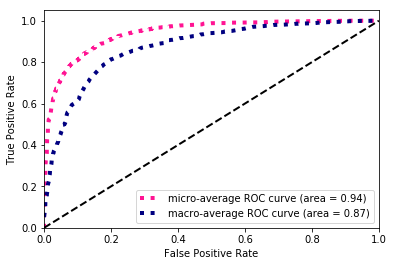

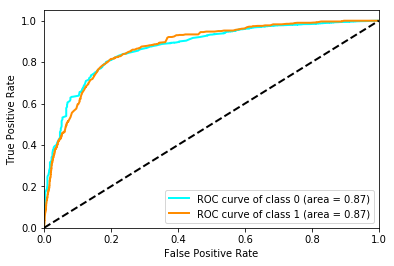

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.916908    0.528275     0.722592     0.858705      0.850164
precision     0.893805    0.619128     0.756466     0.858705      0.846632
recall        0.941237    0.460674     0.700956     0.858705      0.858705
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.872453    0.872453     0.872601     0.939376           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 195)
(22890, 2)
(4664, 195)
(4664, 2)
(22890, 8, 10)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

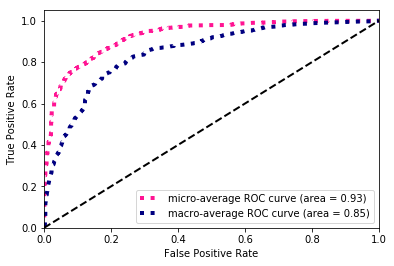

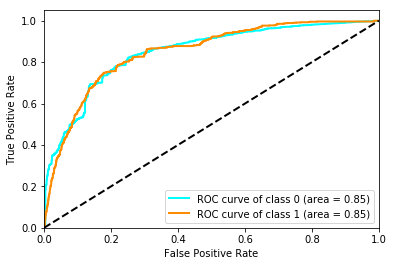

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.903964    0.547459     0.725711     0.841552      0.842737
precision     0.907620    0.537260     0.722440     0.841552      0.844014
recall        0.900337    0.558052     0.729194     0.841552      0.841552
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.847676    0.847676     0.847951     0.926497           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 195)
(22890, 2)
(4664, 195)
(4664, 2)
(22890, 8, 10)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

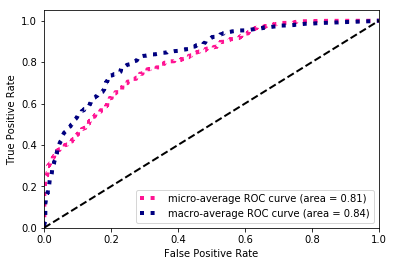

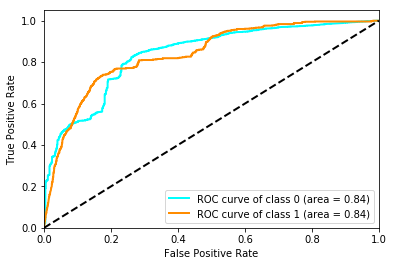

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.809898    0.502520     0.656209     0.724914      0.757108
precision     0.946985    0.364454     0.655720     0.724914      0.846941
recall        0.707481    0.808989     0.758235     0.724914      0.724914
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.837909    0.837909     0.838191     0.808506           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 195)
(22890, 2)
(4664, 195)
(4664, 2)
(22890, 8, 10)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

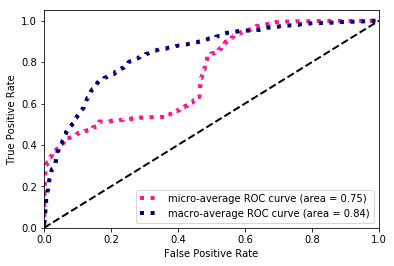

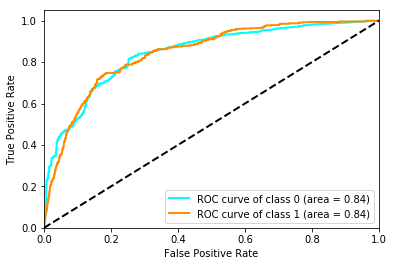

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.673514    0.427855     0.550684     0.584262      0.631324
precision     0.963391    0.280139     0.621765     0.584262      0.846049
recall        0.517732    0.905119     0.711425     0.584262      0.584262
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.843770    0.843770     0.844083     0.747229           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 171)
(22890, 2)
(4664, 171)
(4664, 2)
(22890, 8, 7)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

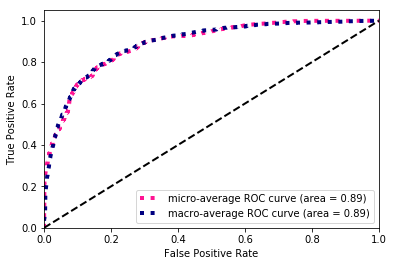

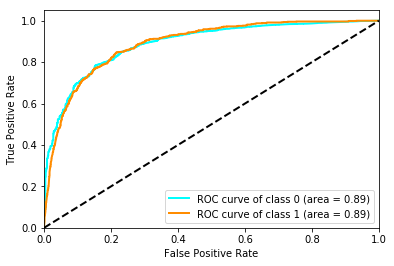

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.870936    0.587494     0.729215     0.803388      0.822257
precision     0.954349    0.459212     0.706781     0.803388      0.869314
recall        0.800932    0.815231     0.808081     0.803388      0.803388
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.889260    0.889260     0.889403     0.889190           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 171)
(22890, 2)
(4664, 171)
(4664, 2)
(22890, 8, 7)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

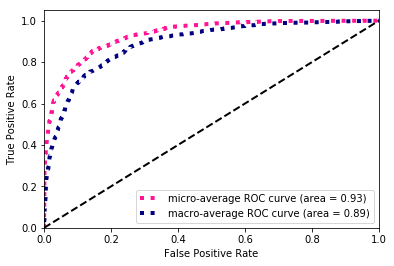

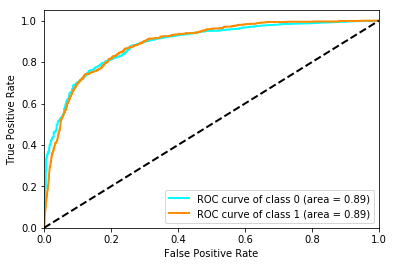

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.908457    0.634172     0.771315     0.853559      0.861351
precision     0.941912    0.555347     0.748630     0.853559      0.875523
recall        0.877297    0.739076     0.808187     0.853559      0.853559
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.890418    0.890418     0.890545     0.932269           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 171)
(22890, 2)
(4664, 171)
(4664, 2)
(22890, 8, 7)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

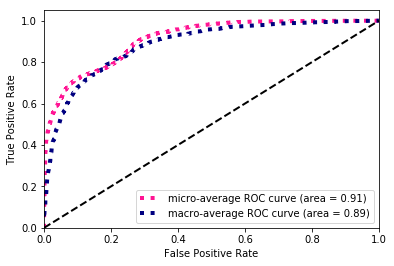

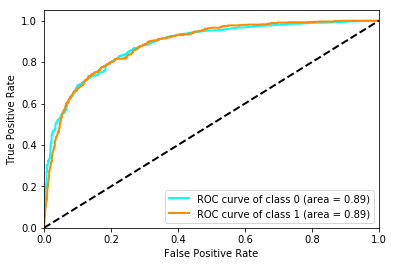

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.863495    0.574581     0.719038     0.793310      0.813876
precision     0.953110    0.444369     0.698739     0.793310      0.865739
recall        0.789283    0.812734     0.801009     0.793310      0.793310
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.885093    0.885093     0.885230     0.910321           NaN

In [28]:
Austin = compare_models(city='Austin',classname='RNN_embed')

In [29]:
Austin.to_hdf('Austin.h5',key='RNN_embed_only')
Austin

traffic   weather      time
0_f1-score              0.890592  0.795792  0.880963
1_f1-score              0.553460  0.492611  0.598749
weighted avg_f1-score   0.832692  0.743723  0.832495
micro avg_f1-score      0.825972  0.716910  0.816752
macro avg_f1-score      0.722026  0.644202  0.739856
0_precision             0.920938  0.939332  0.949791
1_precision             0.523182  0.393951  0.486309
weighted avg_precision  0.852627  0.845668  0.870192
micro avg_precision     0.825972  0.716910  0.816752
macro avg_precision     0.722060  0.666642  0.718050
0_recall                0.866339  0.708517  0.822504
1_recall                0.631294  0.757387  0.789014
weighted avg_recall     0.825972  0.716910  0.816752
micro avg_recall        0.825972  0.716910  0.816752
macro avg_recall        0.748816  0.732952  0.805759
0_auc                   0.862394  0.843118  0.888257
1_auc                   0.862394  0.843118  0.888257
micro avg_auc           0.906061  0.827411  0.910593
macro avg_auc           0.862561  0.843408  0.888393

# Miami

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 100)
(7671, 2)
(1561, 100)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_424 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_425 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_199 (Bat (None, 256)               1024      
_________________________________________________________________
activation_199 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 256)           

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


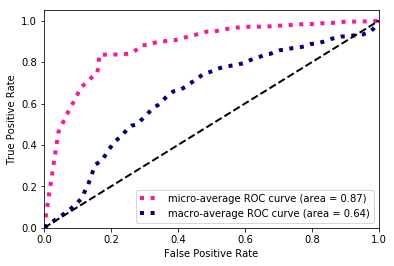

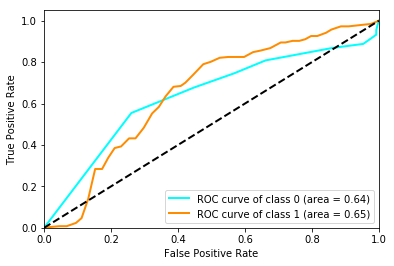

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.637076    0.650255     0.643754     0.874879           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 100)
(7671, 2)
(1561, 100)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_428 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_429 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_201 (Bat (None, 256)               1024      
_________________________________________________________________
activation_201 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 256)           

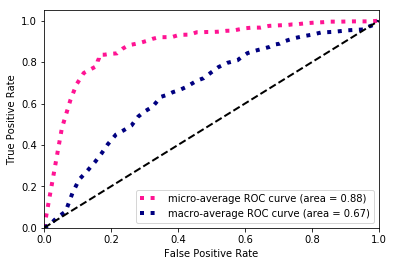

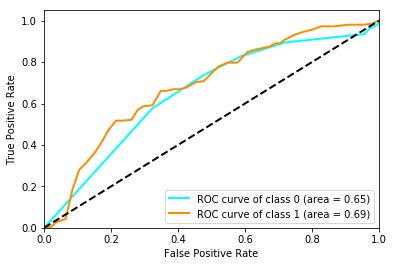

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.653273    0.685092     0.669182     0.881898           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 100)
(7671, 2)
(1561, 100)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_432 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_433 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_203 (Bat (None, 256)               1024      
_________________________________________________________________
activation_203 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_102 (Dropout)        (None, 256)           

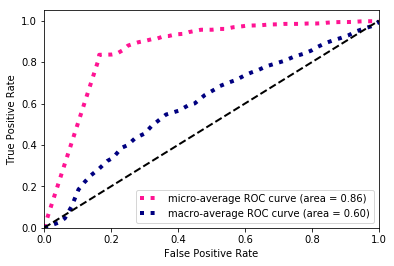

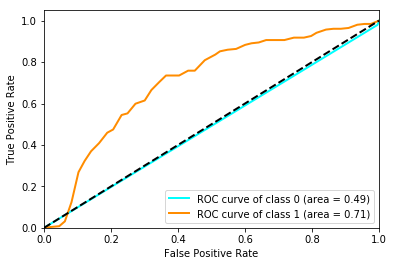

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.491976    0.707137     0.599557     0.862746           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 14)
(7671, 2)
(1561, 14)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_436 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_437 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_205 (Bat (None, 256)               1024      
_________________________________________________________________
activation_205 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 256)             

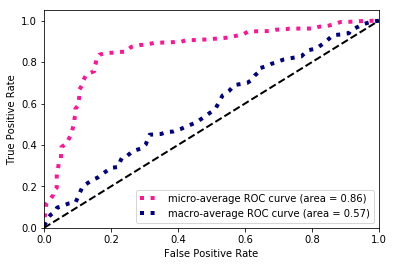

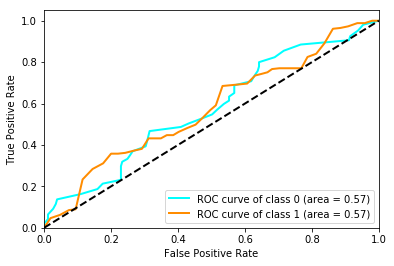

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.574475    0.574475     0.574921     0.855847           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 14)
(7671, 2)
(1561, 14)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_440 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_441 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_207 (Bat (None, 256)               1024      
_________________________________________________________________
activation_207 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 256)             

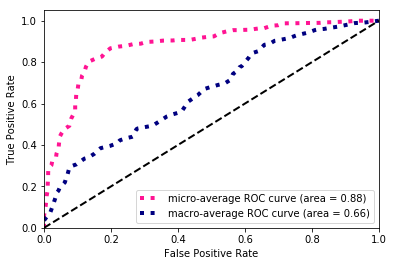

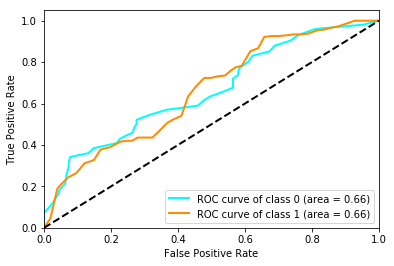

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.904526    0.081633     0.493079     0.827034      0.769047
precision     0.839239    0.324324     0.581782     0.827034      0.754464
recall        0.980828    0.046693     0.513760     0.827034      0.827034
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.660340    0.660340     0.660515     0.879268           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 14)
(7671, 2)
(1561, 14)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_444 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_445 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_209 (Bat (None, 256)               1024      
_________________________________________________________________
activation_209 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 256)             

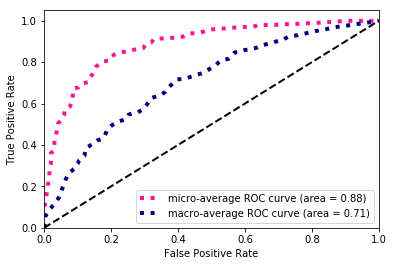

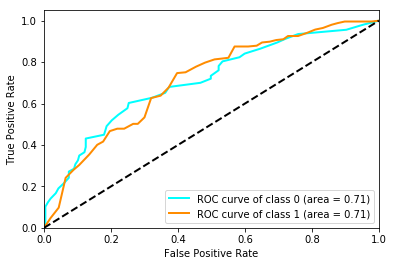

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.887976    0.324324     0.606150     0.807816      0.795178
precision     0.865357    0.385027     0.625192     0.807816      0.786276
recall        0.911810    0.280156     0.595983     0.807816      0.807816
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.708119    0.708119     0.708430     0.884241           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 64)
(7671, 2)
(1561, 64)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_448 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_449 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_211 (Bat (None, 256)               1024      
_________________________________________________________________
activation_211 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 256)             

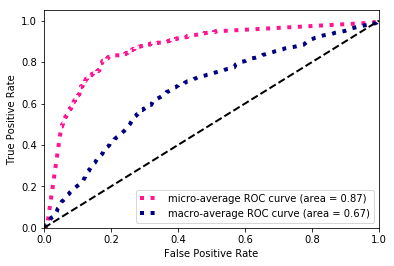

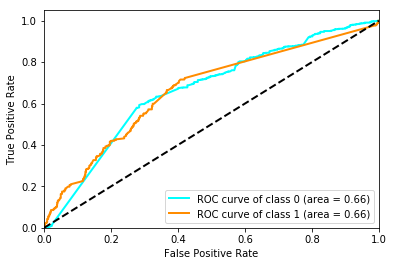

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.893757    0.240209     0.566983     0.813581      0.786158
precision     0.852962    0.365079     0.609021     0.813581      0.772638
recall        0.938650    0.178988     0.558819     0.813581      0.813581
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.664706    0.664706     0.665363     0.865805           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 64)
(7671, 2)
(1561, 64)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_452 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_453 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_213 (Bat (None, 256)               1024      
_________________________________________________________________
activation_213 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 256)             

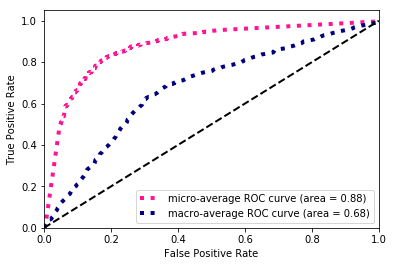

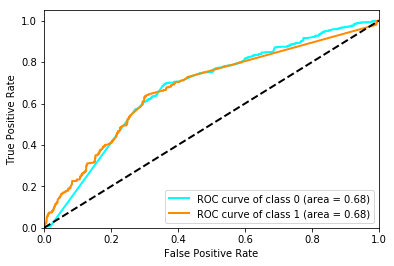

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.898078    0.230137     0.564107     0.819987      0.788109
precision     0.852030    0.388889     0.620460     0.819987      0.775780
recall        0.949387    0.163424     0.556405     0.819987      0.819987
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.675212    0.675212     0.675732     0.877741           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 64)
(7671, 2)
(1561, 64)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_456 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_457 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_215 (Bat (None, 256)               1024      
_________________________________________________________________
activation_215 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 256)             

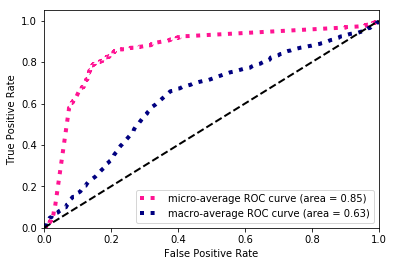

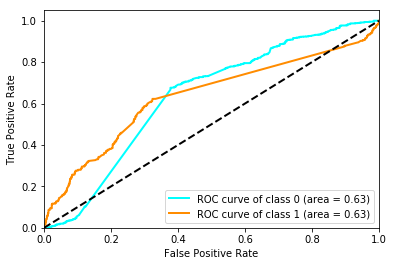

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.896702    0.214876     0.555789     0.817425      0.784447
precision     0.850172    0.367925     0.609048     0.817425      0.770776
recall        0.948620    0.151751     0.550185     0.817425      0.817425
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.634094    0.634094     0.634741     0.853808           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 80)
(7671, 2)
(1561, 80)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_460 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_461 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_217 (Bat (None, 256)               1024      
_________________________________________________________________
activation_217 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 256)             

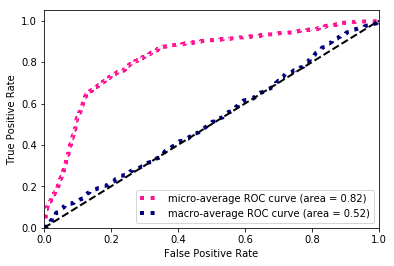

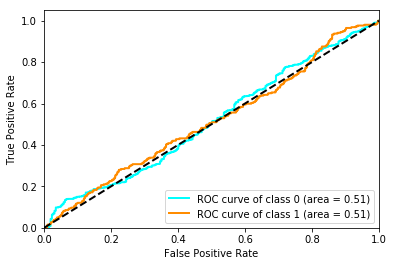

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.861401    0.150685     0.506043     0.761691      0.744390
precision     0.837681    0.182320     0.510001     0.761691      0.729784
recall        0.886503    0.128405     0.507454     0.761691      0.761691
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.514629    0.514629     0.515440     0.822424           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 80)
(7671, 2)
(1561, 80)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_464 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_465 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_219 (Bat (None, 256)               1024      
_________________________________________________________________
activation_219 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 256)             

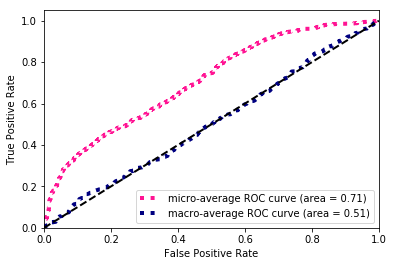

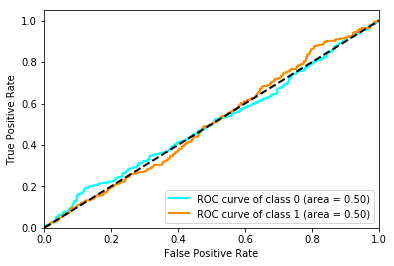

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.753247    0.198639     0.475943     0.622678      0.661937
precision     0.830102    0.152720     0.491411     0.622678      0.718579
recall        0.689417    0.284047     0.486732     0.622678      0.622678
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.504531    0.504531     0.505335     0.706500           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 80)
(7671, 2)
(1561, 80)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_468 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_469 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_221 (Bat (None, 256)               1024      
_________________________________________________________________
activation_221 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 256)             

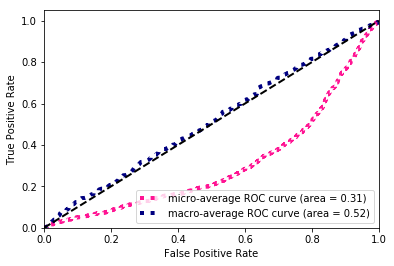

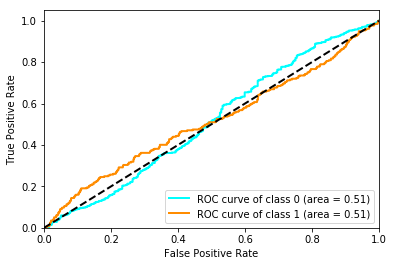

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.410611    0.263689     0.337150     0.345291      0.386422
precision     0.827907    0.161804     0.494855     0.345291      0.718241
recall        0.273006    0.712062     0.492534     0.345291      0.345291
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.514366    0.514366     0.515212     0.307688           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 56)
(7671, 2)
(1561, 56)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_472 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_473 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_223 (Bat (None, 256)               1024      
_________________________________________________________________
activation_223 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 256)             

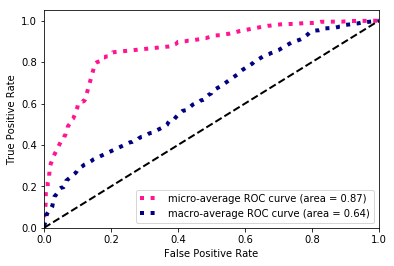

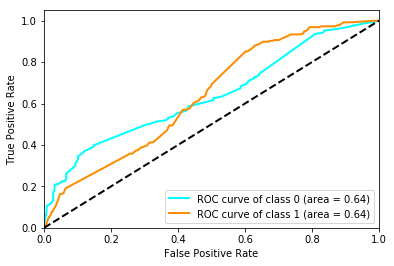

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.899674    0.232687     0.566181     0.822550      0.789863
precision     0.852437    0.403846     0.628141     0.822550      0.778581
recall        0.952454    0.163424     0.557939     0.822550      0.822550
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.637597    0.637597     0.637855     0.865481           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 56)
(7671, 2)
(1561, 56)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_476 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_477 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_225 (Bat (None, 256)               1024      
_________________________________________________________________
activation_225 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 256)             

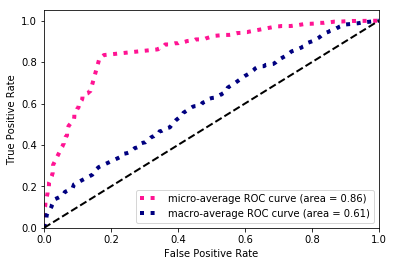

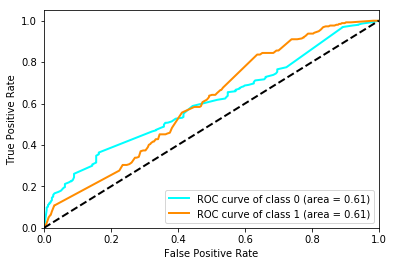

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.903826    0.172308     0.538067     0.827675      0.783390
precision     0.846618    0.411765     0.629191     0.827675      0.775024
recall        0.969325    0.108949     0.539137     0.827675      0.827675
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.606662    0.606719     0.607085     0.858644           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 56)
(7671, 2)
(1561, 56)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_480 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_481 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_227 (Bat (None, 256)               1024      
_________________________________________________________________
activation_227 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 256)             

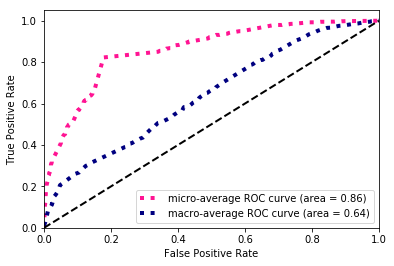

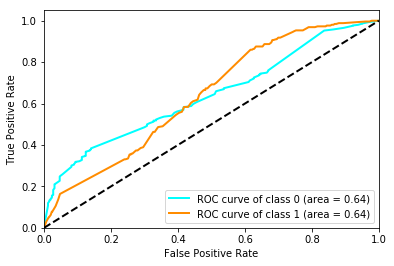

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.899674    0.232687     0.566181     0.822550      0.789863
precision     0.852437    0.403846     0.628141     0.822550      0.778581
recall        0.952454    0.163424     0.557939     0.822550      0.822550
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.639190    0.639190     0.639510     0.857344           NaN

In [30]:
Miami = compare_models(city='Miami',classname='DNN')

In [31]:
Miami.to_hdf('Miami.h5',key='DNN_only')
Miami

NL   geohash   traffic   weather      time
0_f1-score              0.910297  0.900933  0.896179  0.675086  0.901058
1_f1-score              0.000000  0.135319  0.228407  0.204338  0.212561
weighted avg_f1-score   0.760427  0.774884  0.786238  0.597583  0.787705
micro avg_f1-score      0.835362  0.823404  0.816998  0.576553  0.824258
macro avg_f1-score      0.455148  0.518126  0.562293  0.439712  0.556809
0_precision             0.835362  0.846652  0.851721  0.831897  0.850497
1_precision             0.000000  0.236450  0.373964  0.165615  0.406486
weighted avg_precision  0.697830  0.746190  0.773064  0.722201  0.777396
micro avg_precision     0.835362  0.823404  0.816998  0.576553  0.824258
macro avg_precision     0.417681  0.541551  0.612843  0.498756  0.628491
0_recall                1.000000  0.964213  0.945552  0.616309  0.958078
1_recall                0.000000  0.108949  0.164721  0.374838  0.145266
weighted avg_recall     0.835362  0.823404  0.816998  0.576553  0.824258
micro avg_recall        0.835362  0.823404  0.816998  0.576553  0.824258
macro avg_recall        0.500000  0.536581  0.555137  0.495573  0.551672
0_auc                   0.594108  0.647645  0.658004  0.511175  0.627816
1_auc                   0.680828  0.647645  0.658004  0.511175  0.627835
micro avg_auc           0.873175  0.873119  0.865785  0.612204  0.860490
macro avg_auc           0.637498  0.647955  0.658612  0.511996  0.628150

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 178)
(7671, 2)
(1561, 178)
(1561, 2)
(7671, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_109 (LSTM)              (None, 8, 128)            70144     
_________________________________________________________________
lstm_110 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_484 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_485 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_

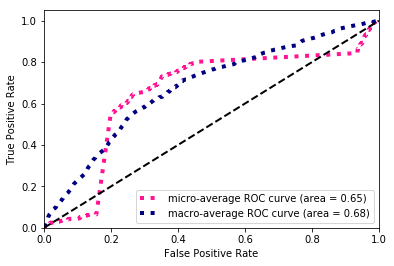

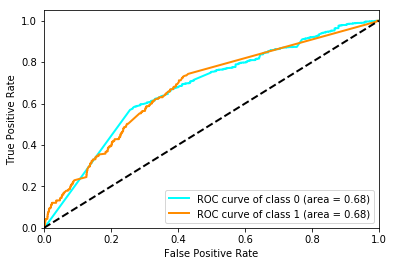

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.784549    0.366162     0.575355     0.678411      0.715667
precision     0.890838    0.271028     0.580933     0.678411      0.788794
recall        0.700920    0.564202     0.632561     0.678411      0.678411
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.676961    0.676961     0.677697     0.651567           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 178)
(7671, 2)
(1561, 178)
(1561, 2)
(7671, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_111 (LSTM)              (None, 8, 128)            70144     
_________________________________________________________________
lstm_112 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_488 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_489 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_

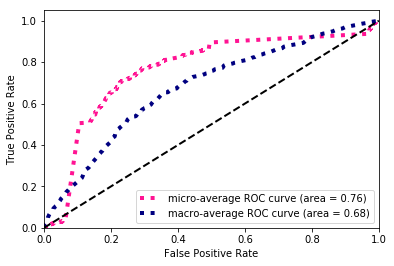

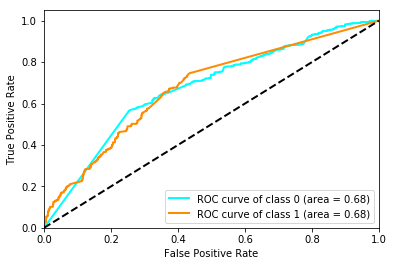

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.833200    0.321429     0.577314     0.732223      0.748943
precision     0.868552    0.275766     0.572159     0.732223      0.770957
recall        0.800613    0.385214     0.592914     0.732223      0.732223
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.675779    0.675779     0.676444     0.762146           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 178)
(7671, 2)
(1561, 178)
(1561, 2)
(7671, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_113 (LSTM)              (None, 8, 128)            70144     
_________________________________________________________________
lstm_114 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_492 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_493 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_

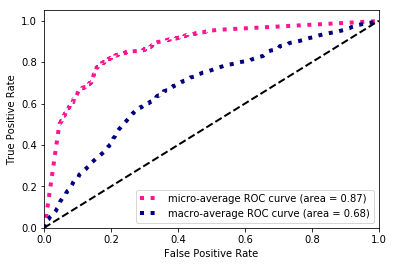

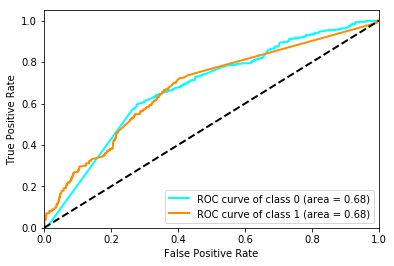

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.892647    0.273632     0.583139     0.812940      0.790734
precision     0.857345    0.379310     0.618327     0.812940      0.778642
recall        0.930982    0.214008     0.572495     0.812940      0.812940
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.677831    0.677838     0.678402     0.872292           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 194)
(7671, 2)
(1561, 194)
(1561, 2)
(7671, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_115 (LSTM)              (None, 8, 128)            71168     
_________________________________________________________________
lstm_116 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_496 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_497 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


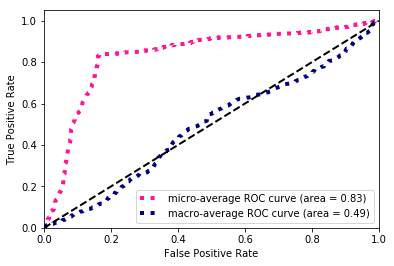

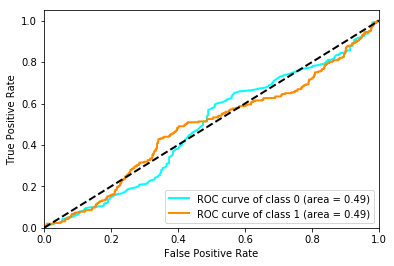

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.486343    0.486442     0.487031     0.831619           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 194)
(7671, 2)
(1561, 194)
(1561, 2)
(7671, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_117 (LSTM)              (None, 8, 128)            71168     
_________________________________________________________________
lstm_118 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_500 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_501 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization

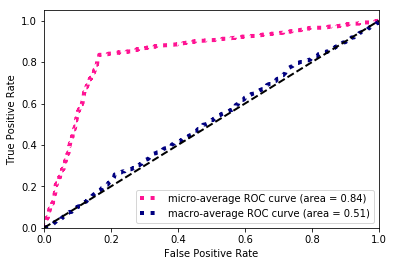

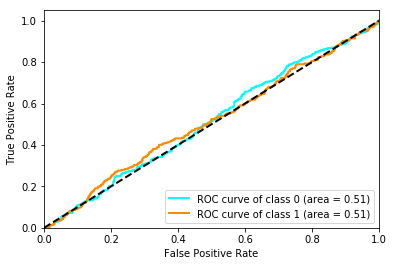

0          1    macro avg    micro avg  weighted avg
index                                                                    
f1-score      0.910297    0.00000     0.455148     0.835362      0.760427
precision     0.835362    0.00000     0.417681     0.835362      0.697830
recall        1.000000    0.00000     0.500000     0.835362      0.835362
support    1304.000000  257.00000  1561.000000  1561.000000   1561.000000
auc           0.513684    0.51369     0.514434     0.839127           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 194)
(7671, 2)
(1561, 194)
(1561, 2)
(7671, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_119 (LSTM)              (None, 8, 128)            71168     
_________________________________________________________________
lstm_120 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_504 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_505 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization

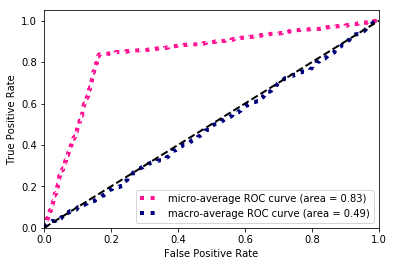

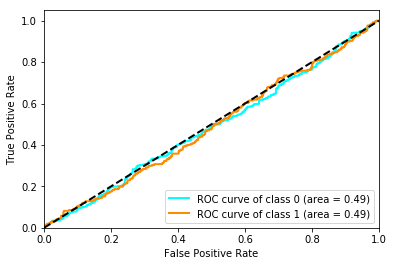

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.487024    0.487026     0.487831     0.831793           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 170)
(7671, 2)
(1561, 170)
(1561, 2)
(7671, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 8, 128)            69632     
_________________________________________________________________
lstm_122 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_508 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_509 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_

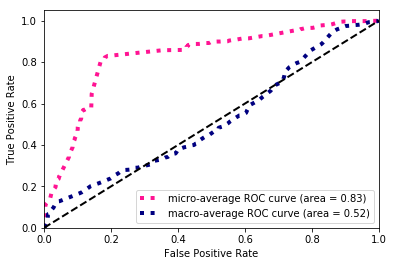

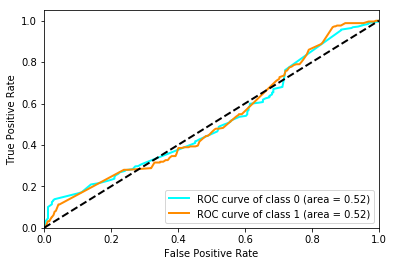

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.899214    0.129630     0.514422     0.819347      0.772511
precision     0.842035    0.313433     0.577734     0.819347      0.755007
recall        0.964724    0.081712     0.523218     0.819347      0.819347
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.516729    0.516729     0.516939     0.828760           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 170)
(7671, 2)
(1561, 170)
(1561, 2)
(7671, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_123 (LSTM)              (None, 8, 128)            69632     
_________________________________________________________________
lstm_124 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_512 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_513 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_

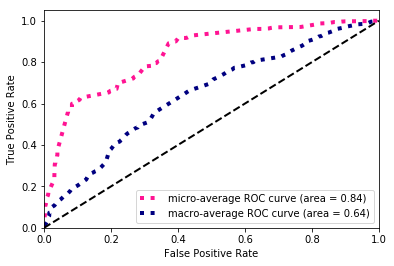

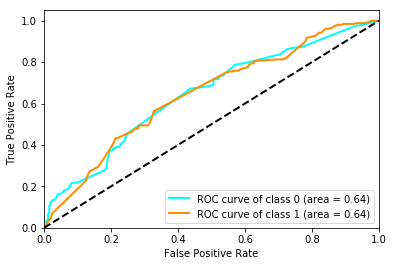

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.830522    0.332278     0.581400     0.729660      0.748492
precision     0.871838    0.280000     0.575919     0.729660      0.774399
recall        0.792945    0.408560     0.600753     0.729660      0.729660
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.644531    0.644531     0.644829     0.837901           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 170)
(7671, 2)
(1561, 170)
(1561, 2)
(7671, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_125 (LSTM)              (None, 8, 128)            69632     
_________________________________________________________________
lstm_126 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_516 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_517 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_

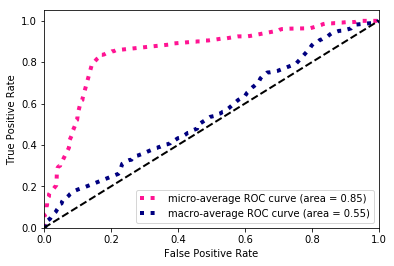

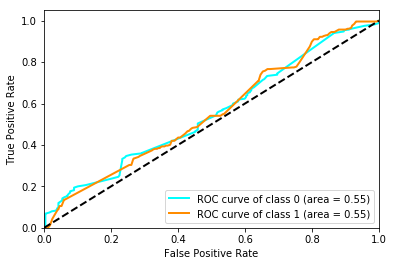

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.551797    0.551797     0.552052     0.849609           NaN

In [32]:
Miami = compare_models(city='Miami',classname='RNN')

In [33]:
Miami.to_hdf('Miami.h5',key='RNN_only')
Miami

traffic   weather      time
0_f1-score              0.836799  0.910297  0.880011
1_f1-score              0.320407  0.000000  0.153969
weighted avg_f1-score   0.751781  0.760427  0.760477
micro avg_f1-score      0.741192  0.835362  0.794790
macro avg_f1-score      0.578603  0.455148  0.516990
0_precision             0.872245  0.835362  0.849745
1_precision             0.308701  0.000000  0.197811
weighted avg_precision  0.779464  0.697830  0.742412
micro avg_precision     0.741192  0.835362  0.794790
macro avg_precision     0.590473  0.417681  0.523778
0_recall                0.810838  1.000000  0.919223
1_recall                0.387808  0.000000  0.163424
weighted avg_recall     0.741192  0.835362  0.794790
micro avg_recall        0.741192  0.835362  0.794790
macro avg_recall        0.599323  0.500000  0.541324
0_auc                   0.676857  0.495684  0.571019
1_auc                   0.676859  0.495720  0.571019
micro avg_auc           0.762002  0.834180  0.838757
macro avg_auc           0.677514  0.496432  0.571273

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 179)
(7671, 2)
(1561, 179)
(1561, 2)
(7671, 8, 8)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_1

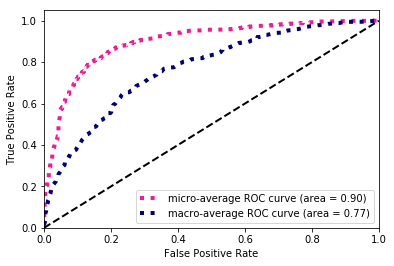

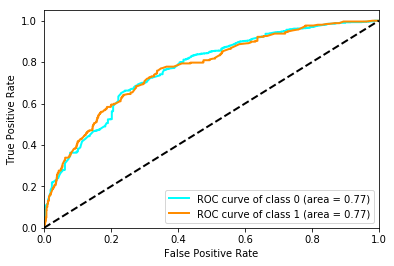

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.898725    0.407895     0.653310     0.827034      0.817915
precision     0.879589    0.467337     0.673463     0.827034      0.811716
recall        0.918712    0.361868     0.640290     0.827034      0.827034
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.768139    0.768139     0.768727     0.897665           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 179)
(7671, 2)
(1561, 179)
(1561, 2)
(7671, 8, 8)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_1

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


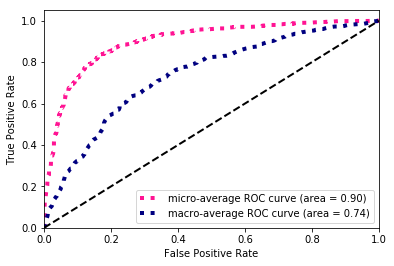

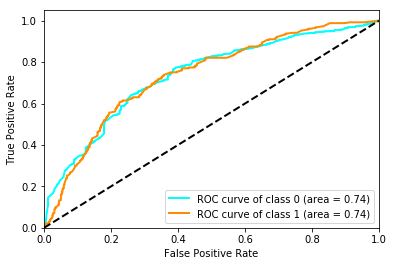

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.735218    0.735235     0.735837     0.900064           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 179)
(7671, 2)
(1561, 179)
(1561, 2)
(7671, 8, 8)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_1

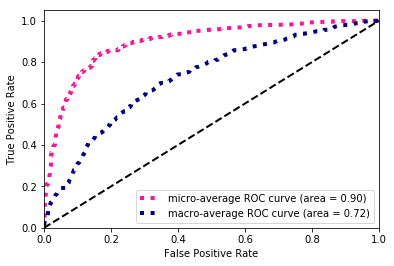

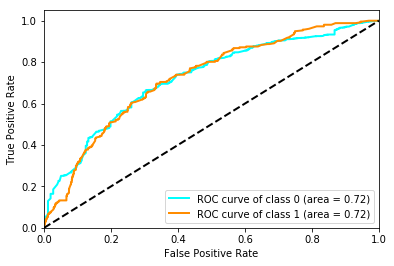

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.723161    0.723133     0.723792     0.896742           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 195)
(7671, 2)
(1561, 195)
(1561, 2)
(7671, 8, 10)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_

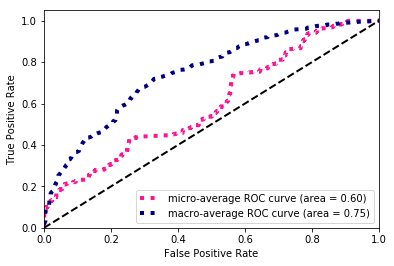

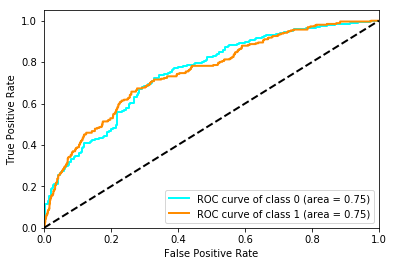

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.621567    0.356401     0.488984     0.523382      0.577910
precision     0.922961    0.229143     0.576052     0.523382      0.808732
recall        0.468558    0.801556     0.635057     0.523382      0.523382
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.748147    0.748145     0.749208     0.602438           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 195)
(7671, 2)
(1561, 195)
(1561, 2)
(7671, 8, 10)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_

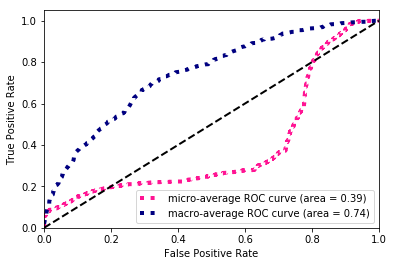

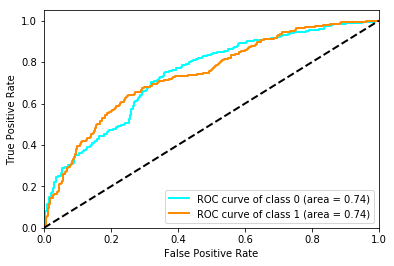

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.325463    0.320257     0.322860     0.322870      0.324606
precision     0.969582    0.191834     0.580708     0.322870      0.841535
recall        0.195552    0.968872     0.582212     0.322870      0.322870
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.740687    0.740687     0.741790     0.392765           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 195)
(7671, 2)
(1561, 195)
(1561, 2)
(7671, 8, 10)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_

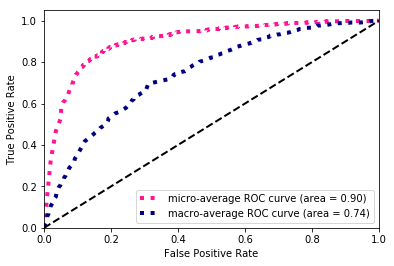

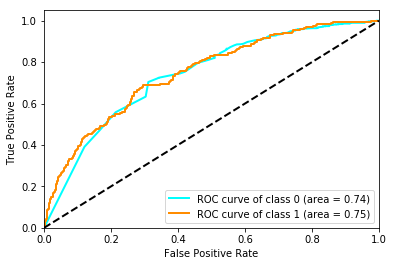

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.738561    0.747383     0.743797     0.902195           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 171)
(7671, 2)
(1561, 171)
(1561, 2)
(7671, 8, 7)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_1

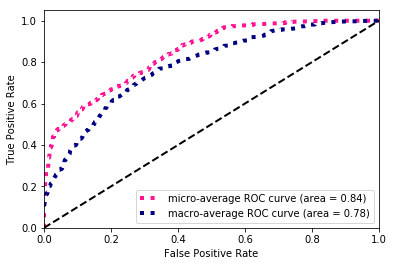

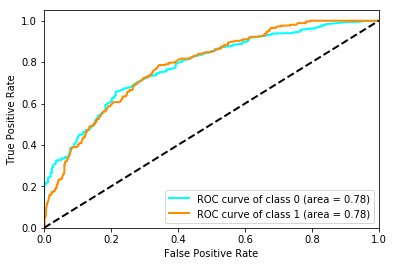

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.824324    0.448276     0.636300     0.733504      0.762412
precision     0.917293    0.340040     0.628667     0.733504      0.822255
recall        0.748466    0.657588     0.703027     0.733504      0.733504
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.781649    0.781649     0.782008     0.843037           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 171)
(7671, 2)
(1561, 171)
(1561, 2)
(7671, 8, 7)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_1

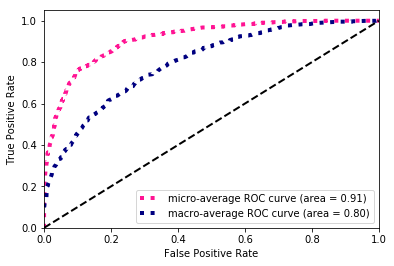

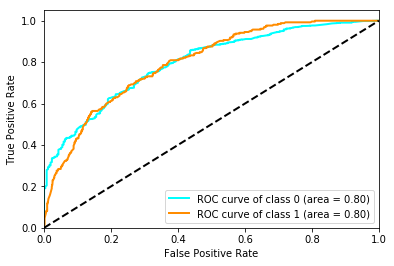

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.899399    0.414847     0.657123     0.828315      0.819624
precision     0.880882    0.472637     0.676760     0.828315      0.813670
recall        0.918712    0.369650     0.644181     0.828315      0.828315
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.797509    0.797509     0.797901     0.912193           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 171)
(7671, 2)
(1561, 171)
(1561, 2)
(7671, 8, 7)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
lstm_1

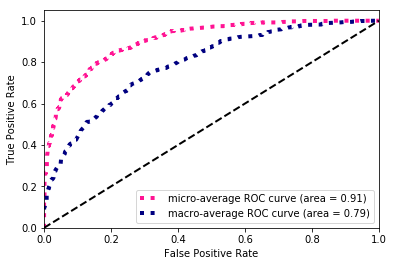

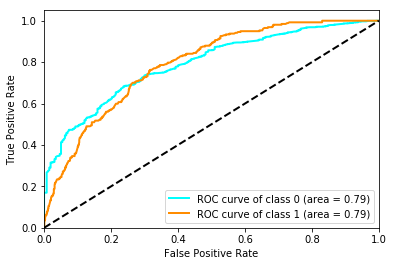

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.890411    0.417004     0.653708     0.815503      0.812470
precision     0.883686    0.434599     0.659142     0.815503      0.809749
recall        0.897239    0.400778     0.649009     0.815503      0.815503
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.790473    0.790473     0.790842     0.905526           NaN

In [34]:
Miami = compare_models(city='Miami',classname='RNN_embed')

In [35]:
Miami.to_hdf('Miami.h5',key='RNN_embed_only')
Miami

traffic   weather      time
0_f1-score              0.906439  0.619109  0.871378
1_f1-score              0.135965  0.225553  0.426709
weighted avg_f1-score   0.779590  0.554314  0.798169
micro avg_f1-score      0.832586  0.560538  0.792441
macro avg_f1-score      0.521202  0.422331  0.649044
0_precision             0.850104  0.909301  0.893954
1_precision             0.155779  0.140326  0.415759
weighted avg_precision  0.735792  0.782699  0.815225
micro avg_precision     0.832586  0.560538  0.792441
macro avg_precision     0.502942  0.524814  0.654856
0_recall                0.972904  0.554703  0.854806
1_recall                0.120623  0.590143  0.476005
weighted avg_recall     0.832586  0.560538  0.792441
micro avg_recall        0.832586  0.560538  0.792441
macro avg_recall        0.546763  0.572423  0.665405
0_auc                   0.742173  0.742465  0.789877
1_auc                   0.742169  0.745405  0.789877
micro avg_auc           0.898157  0.632466  0.886919
macro avg_auc           0.742785  0.744932  0.790250